### Noise calculations for paper revisions


This notebook explores the model training noise as requested during the first round of paper review.

We use the conda environment `analysis`


#### Define some useful functions

In [17]:
import pandas as pd
pd.options.mode.chained_assignment = None #Ignore SettingWithCopyWarning - we are safe here

def load_predictions(path):

    df = pd.read_parquet(path+'predictions.parquet')
    
    
    #Calculate some extra columns
    df['model_predicion_bias'] = df.MODIS_LST - df.predictions
    df['model_predicion_error'] = df.MODIS_LST - df.predictions
        
    df['ERA_predicion_bias'] = df.MODIS_LST - df.skt_unnormalised
    df['ERA_predicion_error'] = abs(df.MODIS_LST - df.skt_unnormalised)


    print ('----------------------------------MODEL-------------------------------------------------')
    print("Mean/Median/Std prediction bias:", df['model_predicion_bias'].mean(), df['model_predicion_bias'].median(),df['model_predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['model_predicion_error'].mean(), df['model_predicion_error'].median(),df['model_predicion_error'].std())

    
    #Average predictions and errors over the year
    df_grouped = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() 
    
    
    
    
    
    return df,df_grouped



def surface_noise_numbers(df):
    
 
    
    print("Numer of grid points:", len(df))
    print("Median variance:", df['variance'].median())
    print("Mean variance:", df['variance'].mean())
    
    print("Median median error:", df['median_error'].median())
    print("Mean mean error:", df['mean_error'].mean())
    
  

    return df['variance'].median()
    
    
    
    
def pipeline(models_to_compare,ID):
    
    annually_averaged_dfs = []
    for m in models_to_compare:
        predictions,predictions_averaged = load_predictions(m)
        annually_averaged_dfs.extend([predictions_averaged])
        
        
        
    change_in_fields = pd.read_pickle('tmp_data/change_in_fields.pkl')
    change_in_fields['latitude_join'] = round(change_in_fields.latitude_ERA,3)
    change_in_fields['longitude_join'] = round(change_in_fields.longitude_ERA,3) #just used for joining due to loss of precision from Margs file
    
    
    
    
    #Create a new df that will just hold the differences   

    df =annually_averaged_dfs[0] #pick a df to get latitudes 
    data = { 'latitude_ERA':     df.latitude_ERA, 
             'longitude_ERA':    df.longitude_ERA,
             'MODIS_LST':        df.MODIS_LST,
             'latitude_join':    round(df.latitude_ERA,3), 
             'longitude_join':    round(df.longitude_ERA,3)}


    i = 1
    selected_cols = [] #we will use this later when computing variances
    for df in annually_averaged_dfs:
        data[f'prediction_error_{i}'] = df['model_predicion_error']
        data[f'prediction_{i}'] = df['predictions']

        selected_cols.extend([f'prediction_error_{i}'])
        i = i+1

    df_new = pd.DataFrame(data)  
    
    
    
    #Join and save
    df_cat = pd.merge(df_new,change_in_fields,how='inner',on=['latitude_join', 'longitude_join'],suffixes=('', '_y')) #inner join.
    df_cat = df_cat.drop(['latitude_join', 'longitude_join','latitude_ERA_y', 'longitude_ERA_y'], axis=1) #Get rid of junk columns
    
    
    

        
    df_cat['median_error']=df_cat[selected_cols].median(axis=1) # median over the prediciton errors for each grid point
    df_cat['mean_error']  =df_cat[selected_cols].mean(axis=1)     # mean over the prediciton errors for each grid point
    df_cat['variance']    =df_cat[selected_cols].std(axis=1)        # variance over the prediciton errors for each grid point i.e. noise
    
    df_cat['label'] = ID
    return df_cat
            

In [18]:
import matplotlib.pyplot as plt 

In [19]:
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/'

In [20]:
import warnings
warnings.filterwarnings("ignore") #ignore FutureWarning statements

In [21]:

#V15
model_1 = f'{root}V15_noise_expt_1/'
model_2 = f'{root}V15_noise_expt_2/'
model_3 = f'{root}V15_noise_expt_3/'
model_4 = f'{root}V15_noise_expt_4/'
models_to_compare = [model_1,model_2, model_3,model_4]
df_V15 = pipeline(models_to_compare,'V15')


----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.08259364 0.226959228515625 3.8190529346466064
Mean/Median/Std prediction error: 0.08259364 0.226959228515625 3.8190529346466064
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.17329945 0.29364013671875 3.8254127502441406
Mean/Median/Std prediction error: 0.17329945 0.29364013671875 3.8254127502441406
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.0777295 0.20306396484375 3.8673462867736816
Mean/Median/Std prediction error: 0.0777295 0.20306396484375 3.8673462867736816
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.06500694 0.195526123046875 3.8166935443878174
Mean/Median/Std prediction error: 0.06500694 0.195526123046875 3.816693544387817

In [22]:

#V20
model_1 = f'{root}V20_noise_expt_1/'
model_2 = f'{root}V20_noise_expt_2/'
model_3 = f'{root}V20_noise_expt_3/'
model_4 = f'{root}V20_noise_expt_4/'
models_to_compare = [model_1,model_2, model_3,model_4]
df_V20 = pipeline(models_to_compare,'V20')

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.03033202 0.1646728515625 3.752133846282959
Mean/Median/Std prediction error: 0.03033202 0.1646728515625 3.752133846282959
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: -0.007963768 0.139404296875 3.738788366317749
Mean/Median/Std prediction error: -0.007963768 0.139404296875 3.738788366317749
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.007012897 0.1645050048828125 3.75597882270813
Mean/Median/Std prediction error: 0.007012897 0.1645050048828125 3.75597882270813
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.09345146 0.24273681640625 3.766803503036499
Mean/Median/Std prediction error: 0.09345146 0.24273681640625 3.766803503036499


In [23]:
#V15X
model_1 = f'{root}V15X_noise_expt_1/'
model_2 = f'{root}V15X_noise_expt_2/'
model_3 = f'{root}V15X_noise_expt_3/'
model_4 = f'{root}V15X_noise_expt_4/'
models_to_compare = [model_1,model_2, model_3,model_4]
df_V15X = pipeline(models_to_compare,'V15X')

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.11968606 0.256805419921875 3.8112101554870605
Mean/Median/Std prediction error: 0.11968606 0.256805419921875 3.8112101554870605
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.13466427 0.283203125 3.8165290355682373
Mean/Median/Std prediction error: 0.13466427 0.283203125 3.8165290355682373
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.116345696 0.249847412109375 3.7914483547210693
Mean/Median/Std prediction error: 0.116345696 0.249847412109375 3.7914483547210693
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.095885955 0.227081298828125 3.8253984451293945
Mean/Median/Std prediction error: 0.095885955 0.227081298828125 3.8253984451293945


In [24]:
#V20X
model_1 = f'{root}V20X_noise_expt_1/'
model_2 = f'{root}V20X_noise_expt_2/'
model_3 = f'{root}V20X_noise_expt_3/'
model_4 = f'{root}V20X_noise_expt_4/'
models_to_compare = [model_1,model_2, model_3,model_4]
df_V20X = pipeline(models_to_compare,'V20X')

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.027514113 0.176727294921875 3.726653814315796
Mean/Median/Std prediction error: 0.027514113 0.176727294921875 3.726653814315796
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.09134957 0.246063232421875 3.7221148014068604
Mean/Median/Std prediction error: 0.09134957 0.246063232421875 3.7221148014068604
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.0630729 0.195037841796875 3.746485471725464
Mean/Median/Std prediction error: 0.0630729 0.195037841796875 3.746485471725464
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.0765716 0.221038818359375 3.7533504962921143
Mean/Median/Std prediction error: 0.0765716 0.221038818359375 3.753350496292114

## Categories 

In [25]:
lake_condition        = 'clFr_change_is_significant & dl_change_is_significant & not oceanFr_change_is_significant & not si10Fr_change_is_significant'
lake_ground_condition = 'clFr_change_is_significant & dl_change_is_significant & not oceanFr_change_is_significant & not cvhFr_change_is_significant & not cvlFr_change_is_significant'
vegetation_condition  = 'cvhFr_change_is_significant & not clFr_change_is_significant'
glacier_condition     = 'si10Fr_change_is_significant'


#### LAKES

In [26]:
df_lake_v15 = df_V15.query(lake_condition)
df_lake_v20 = df_V20.query(lake_condition)
df_lake_v15X = df_V15X.query(lake_condition)
df_lake_v20X = df_V20X.query(lake_condition)

In [50]:

import matplotlib.pyplot as plt




def histograms_and_deltas(df,df_reference,label):
    
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
    #Histogram of the mean error
    df_reference['mean_error'].hist(bins=100,ax=ax,label="V15")
    print("Mean = ", df_reference['mean_error'].mean())
    print("Median = ", df_reference['mean_error'].median())

    #Histogram of the mean error
    df['mean_error'].hist(bins=100,ax=ax,label=label)
    print("Mean = ", df['mean_error'].mean())
    print("Median = ", df['mean_error'].median())

    ax.legend()
    ax.grid(False)
    
    
    print("delta = ",df['mean_error'].mean() - df_reference['mean_error'].mean())
    plt.show()
    
    
    
    print("Noise plots")
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
    #Histogram of the mean error
    df_reference['variance'].hist(bins=100,ax=ax,label="V15")
    print("Mean = ", df_reference['variance'].mean())
    print("Median = ", df_reference['variance'].median())

    #Histogram of the mean error
    df['variance'].hist(bins=100,ax=ax,label=label)
    print("Mean = ", df['variance'].mean())
    print("Median = ", df['variance'].median())

    ax.legend()
    ax.grid(False)
    
    plt.show()
    
    
    
    


import matplotlib.pyplot as plt




def histograms_and_deltas_smart(df,df_reference,label):
    
    plt.rcParams["font.family"] = "serif"
    
    
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    #Histogram of the mean error
    df_reference['mean_error'].hist(bins=100,ax=ax,label="V15")
    print("Mean = ", df_reference['mean_error'].mean())
    print("Median = ", df_reference['mean_error'].median())

    #Histogram of the mean error
    df['mean_error'].hist(bins=100,ax=ax,label=label)
    print("Mean = ", df['mean_error'].mean())
    print("Median = ", df['mean_error'].median())

    ax.legend()
    ax.grid(False)
    ax.set_xlabel('LST MAE [K]')
    
    
#     V15_median =  df_reference['mean_error'].median()
#     V20_median =  df['mean_error'].median()
    
#     ax.axvline(V15_median,linestyle='--',alpha=0.5,c='C0')
#     ax.axvline(V20_median,linestyle='--',alpha=0.5,c="C1")

    plt.savefig(f"images/categories_lakes_histogram_bias.png", bbox_inches="tight",dpi=300)

    plt.show()
    
 

Mean =  0.27753165
Median =  -0.2084273397922516
Mean =  -0.010551279
Median =  -0.03609604388475418


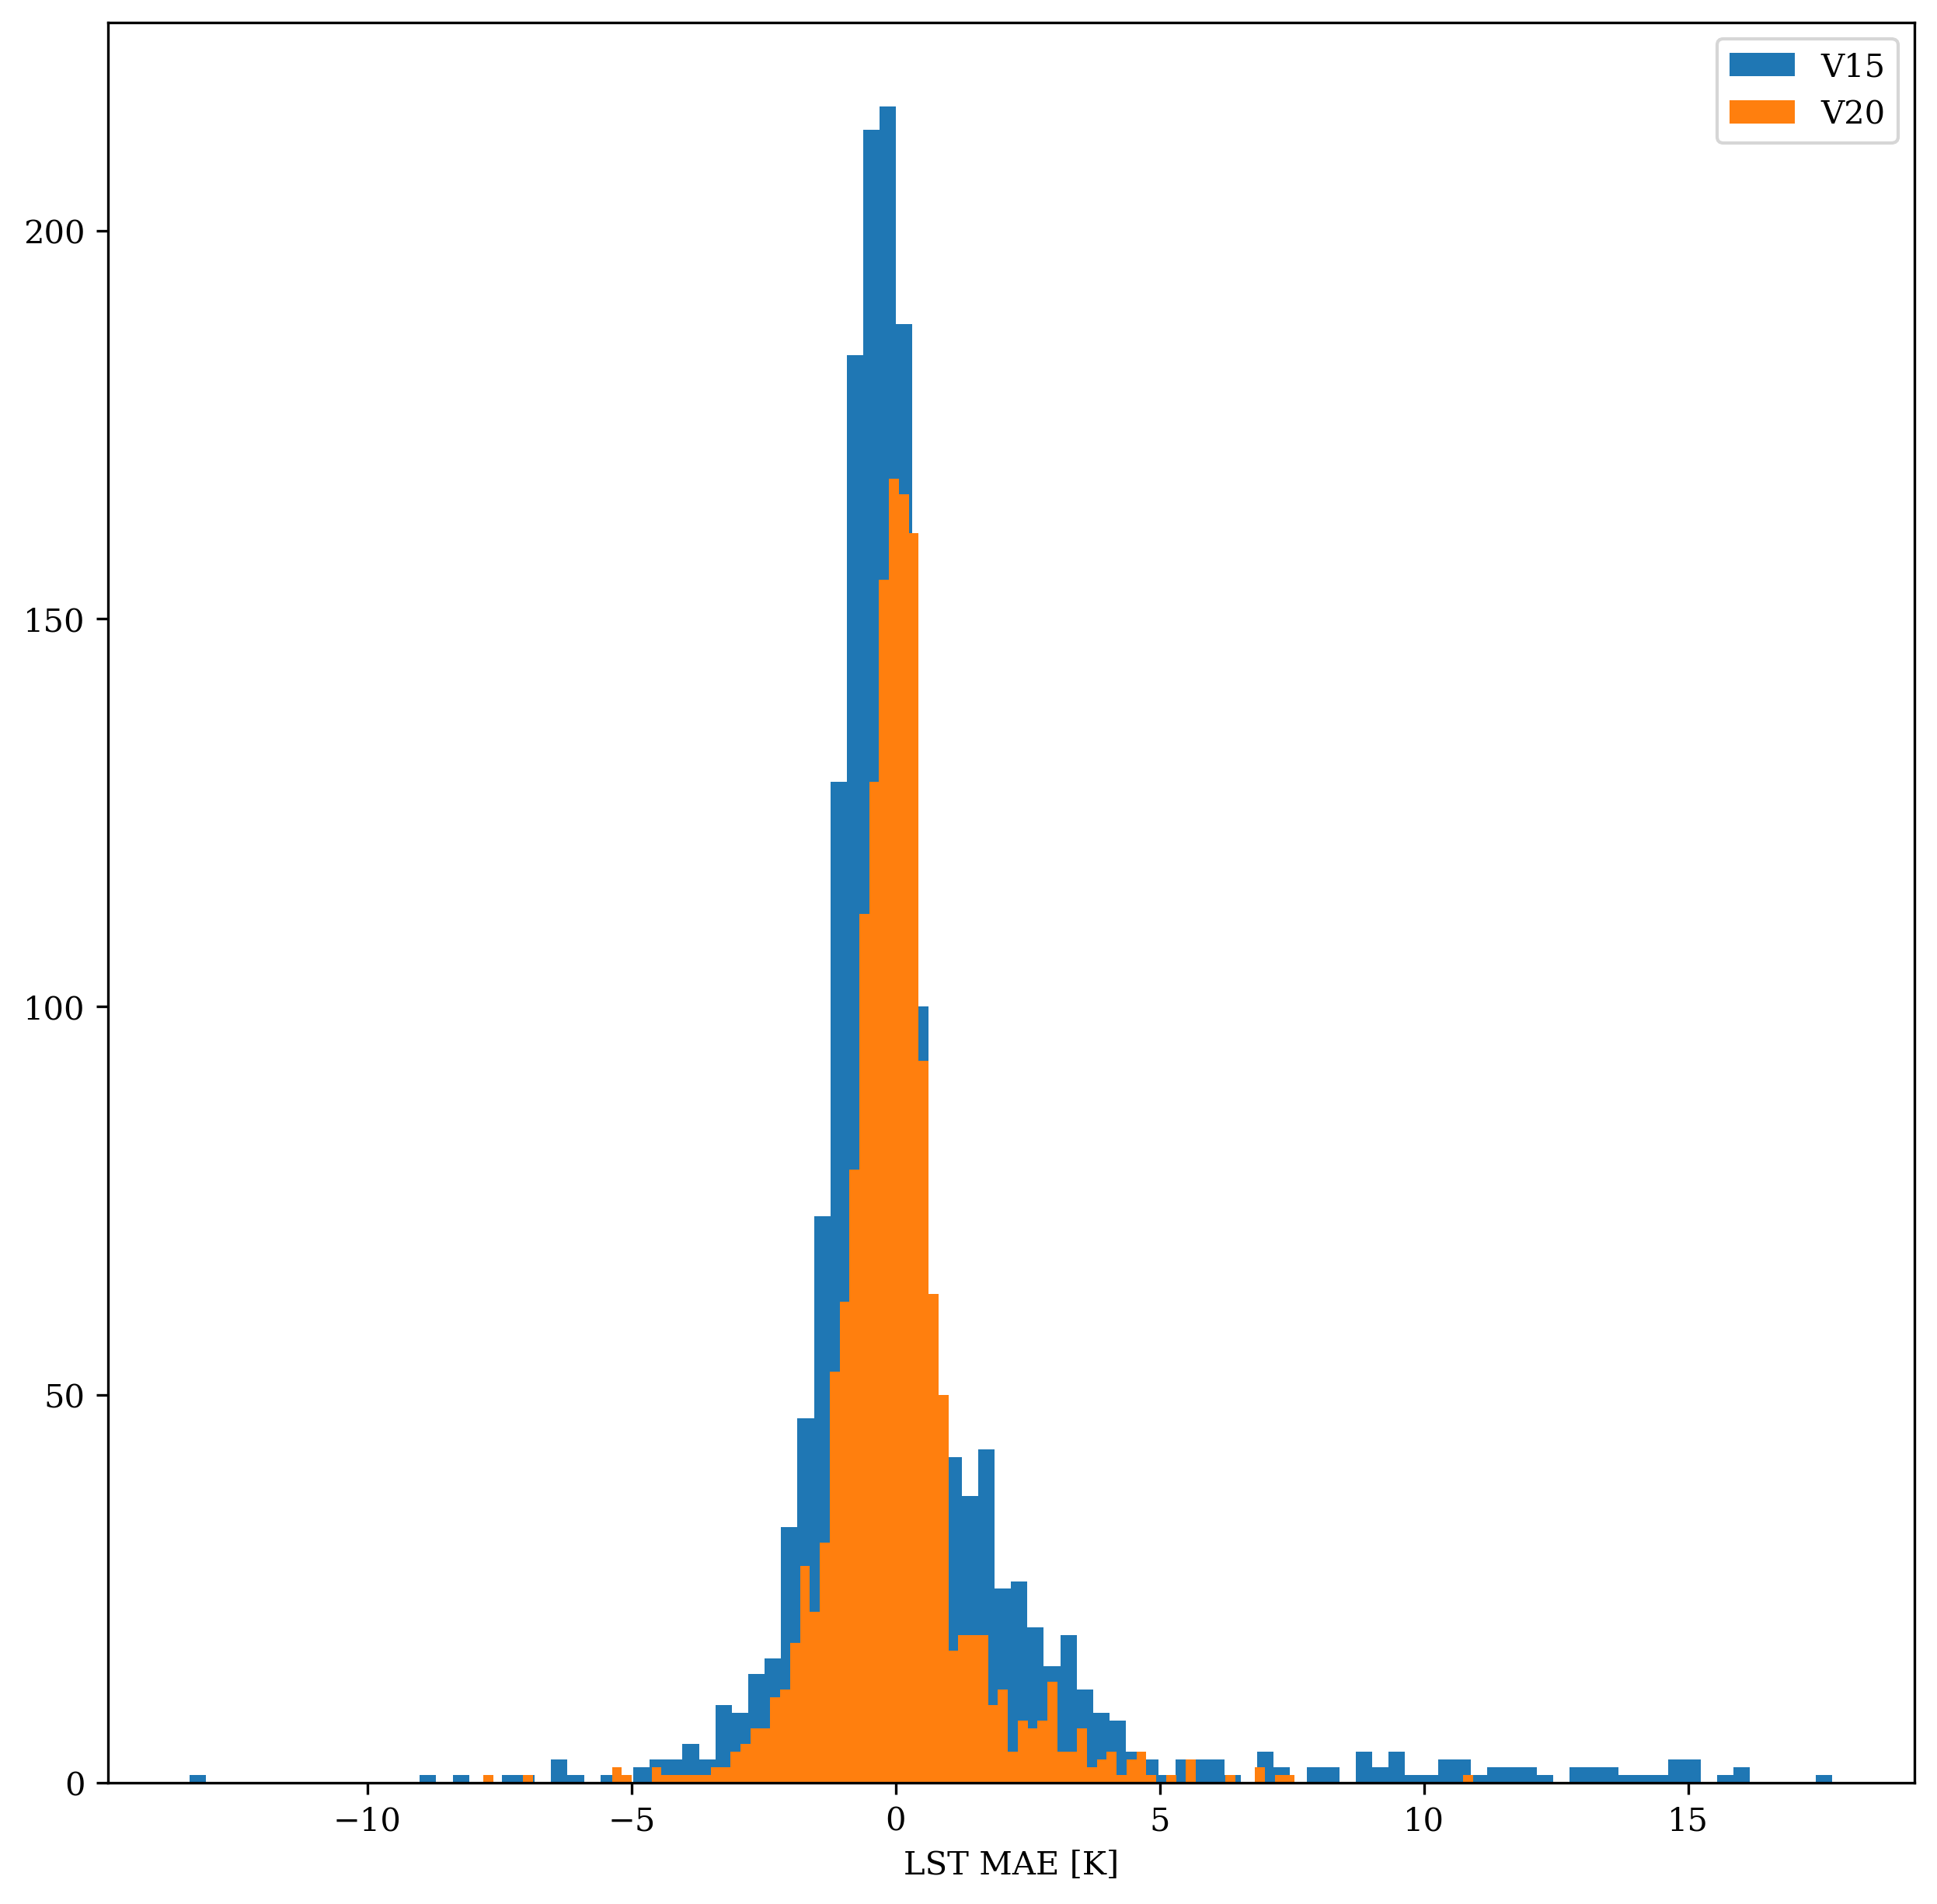

In [51]:
histograms_and_deltas_smart(df_lake_v20,df_lake_v15,label="V20")


Mean =  0.27753165
Median =  -0.2084273397922516
Mean =  -0.010551279
Median =  -0.03609604388475418
delta =  -0.28808293


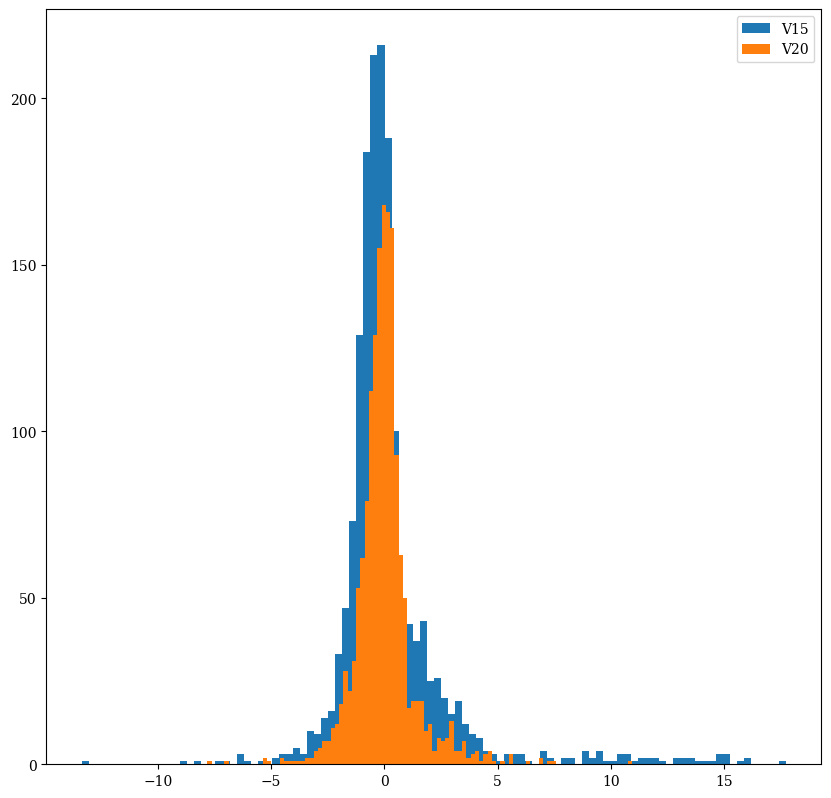

Noise plots
Mean =  0.43593183
Median =  0.28534433245658875
Mean =  0.4056503
Median =  0.2238360494375229


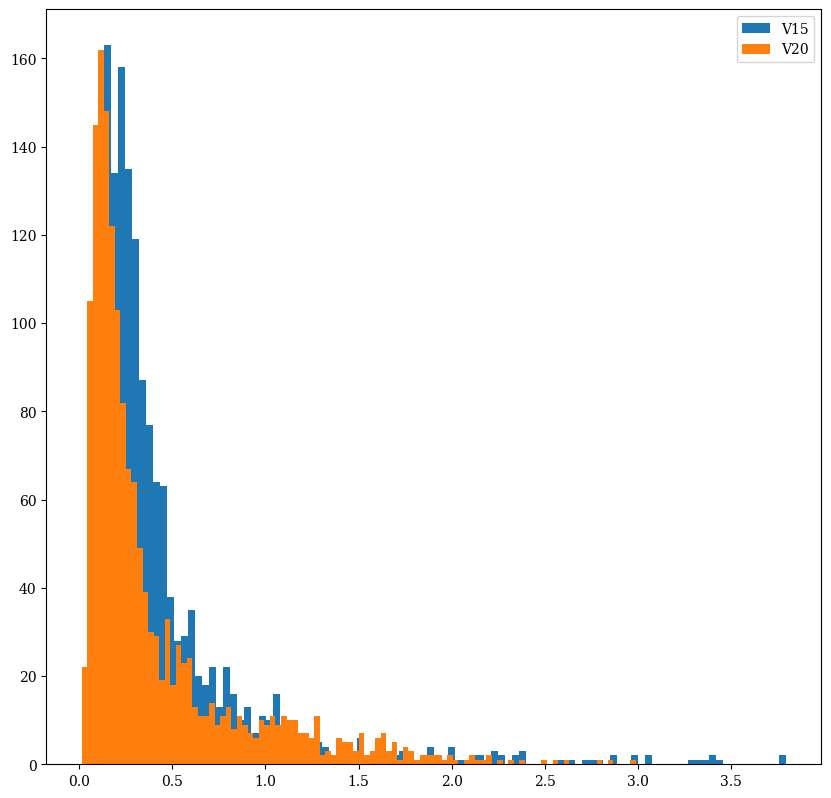

------------------------------
Mean =  0.27753165
Median =  -0.2084273397922516
Mean =  -0.00087496196
Median =  -0.08494796603918076
delta =  -0.27840662


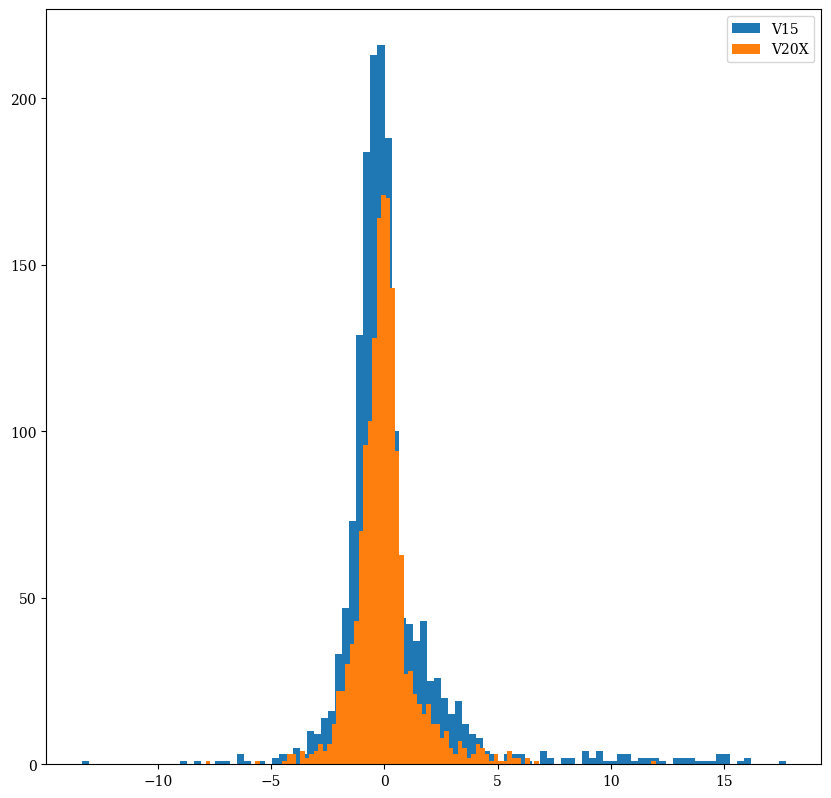

Noise plots
Mean =  0.43593183
Median =  0.28534433245658875
Mean =  0.45196033
Median =  0.2798372805118561


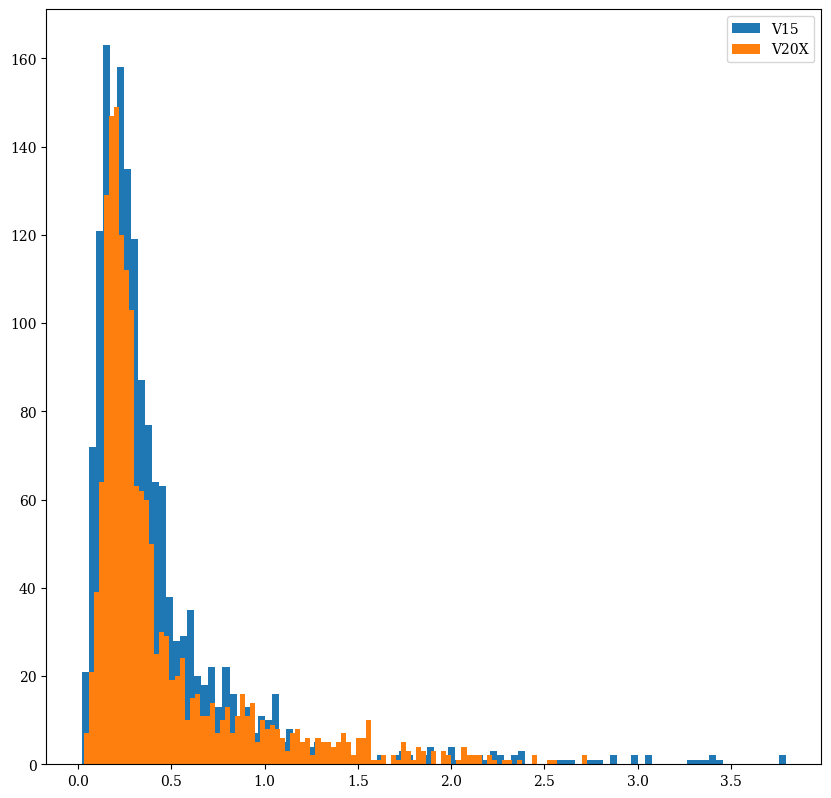

-------------------------------
Mean =  0.27753165
Median =  -0.2084273397922516
Mean =  0.12536697
Median =  -0.20198382437229156
delta =  -0.15216468


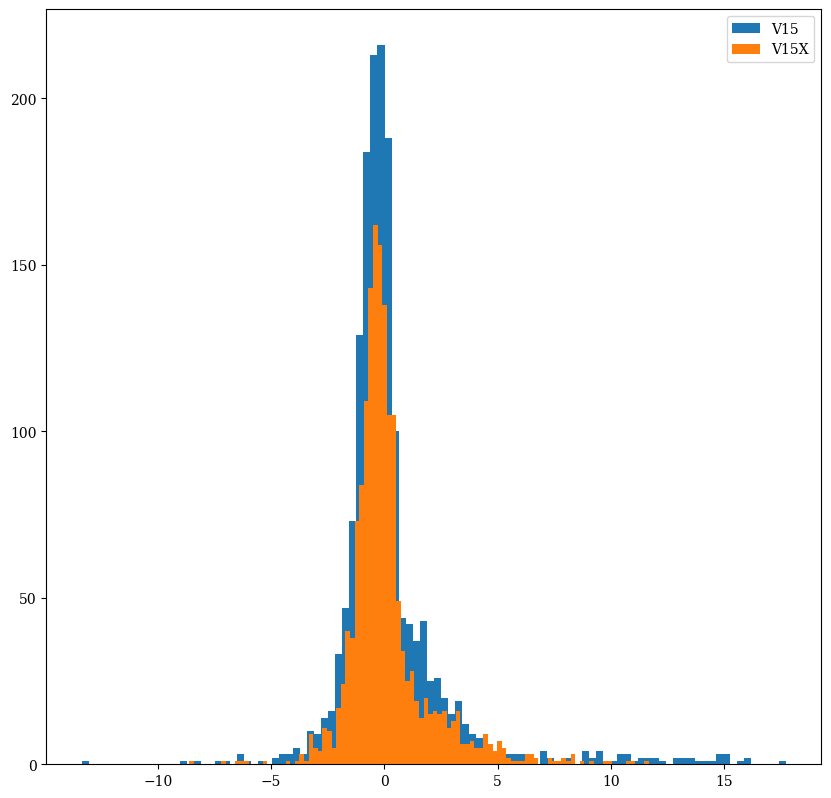

Noise plots
Mean =  0.43593183
Median =  0.28534433245658875
Mean =  0.4537123
Median =  0.2549173831939697


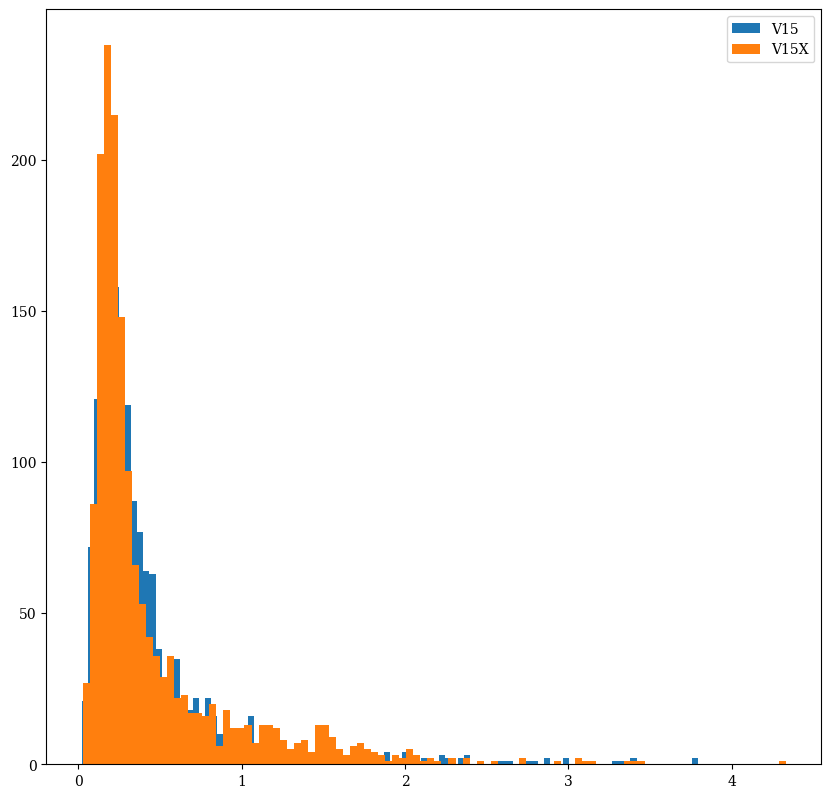

In [29]:
histograms_and_deltas(df_lake_v20,df_lake_v15,label="V20")
print('------------------------------')
histograms_and_deltas(df_lake_v20X,df_lake_v15,label="V20X")
print('-------------------------------')
histograms_and_deltas(df_lake_v15X,df_lake_v15,label="V15X")

#### Lake ground

Mean =  1.2546695
Median =  0.1499892771244049
Mean =  0.22529611
Median =  0.029117129743099213
delta =  -1.0293734


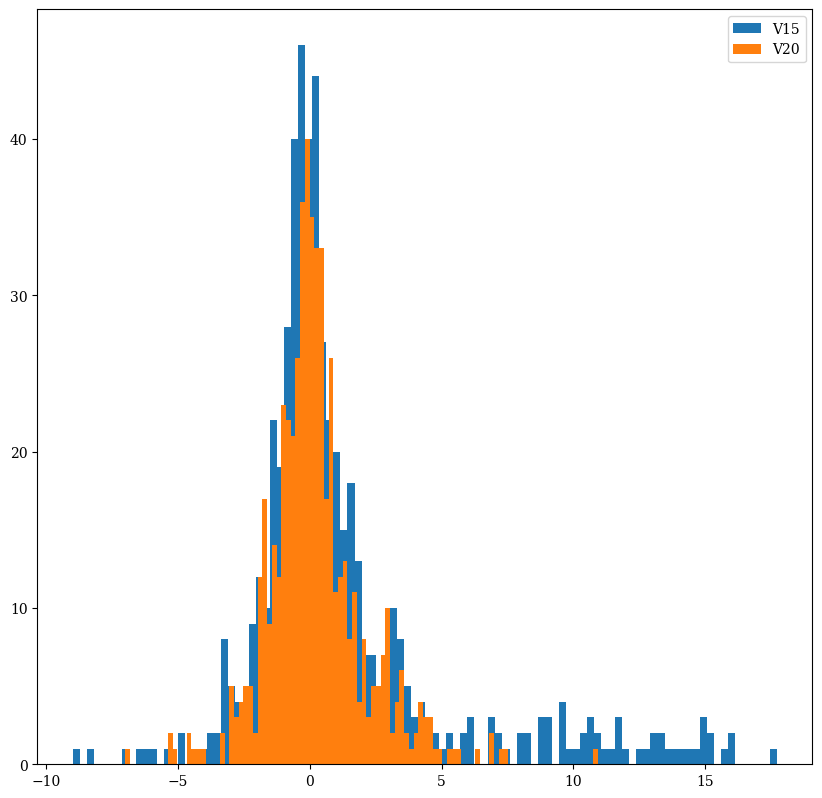

Noise plots
Mean =  0.62830234
Median =  0.44760650396347046
Mean =  0.59330744
Median =  0.40443551540374756


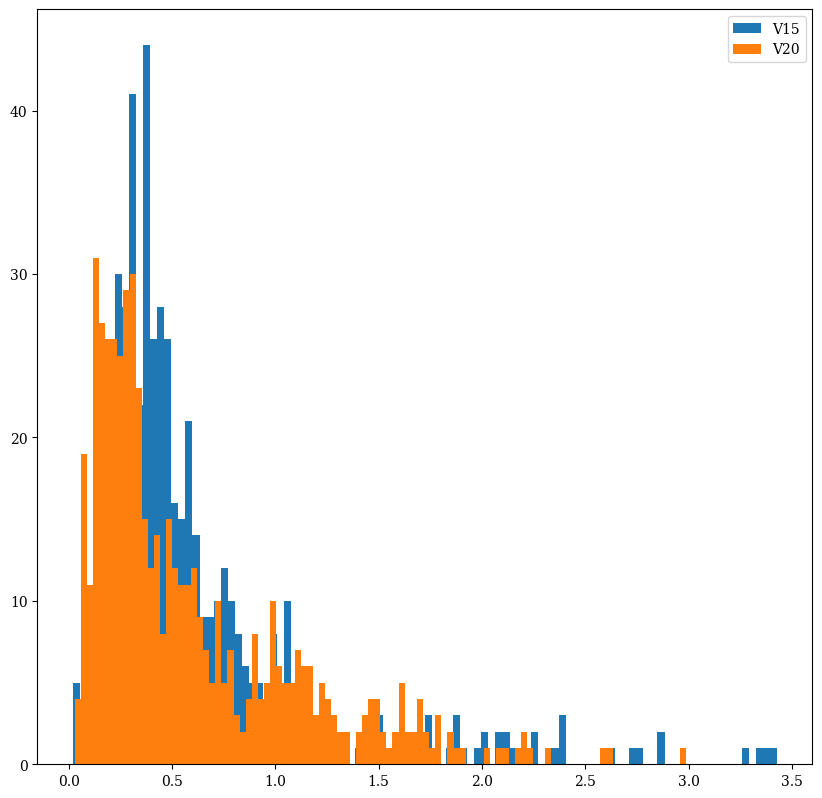

------------------------------
Mean =  1.2546695
Median =  0.1499892771244049
Mean =  -0.00087496196
Median =  -0.08494796603918076
delta =  -1.2555445


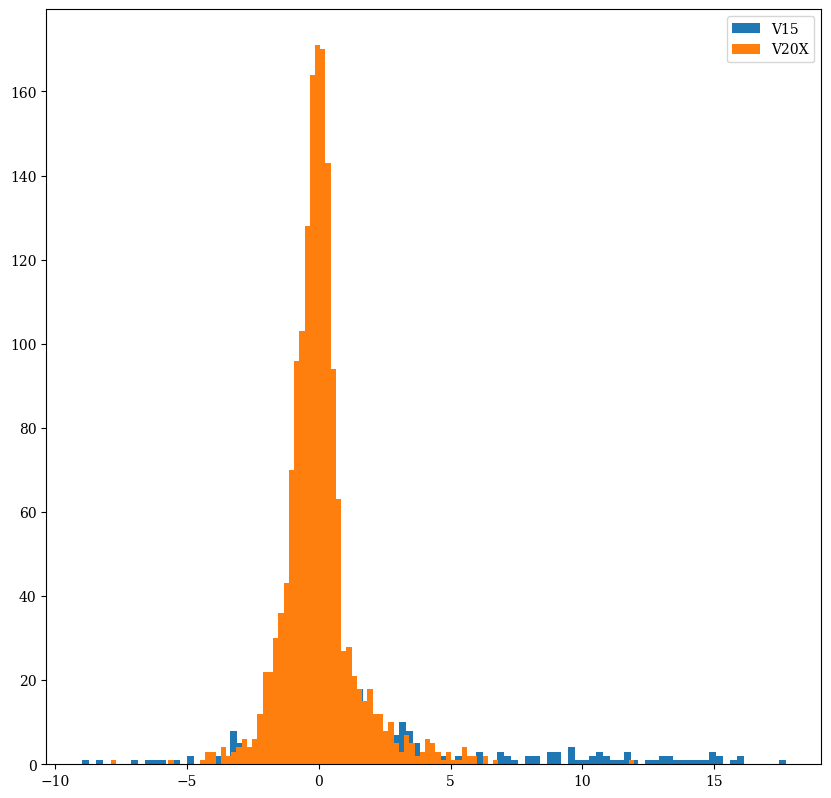

Noise plots
Mean =  0.62830234
Median =  0.44760650396347046
Mean =  0.45196033
Median =  0.2798372805118561


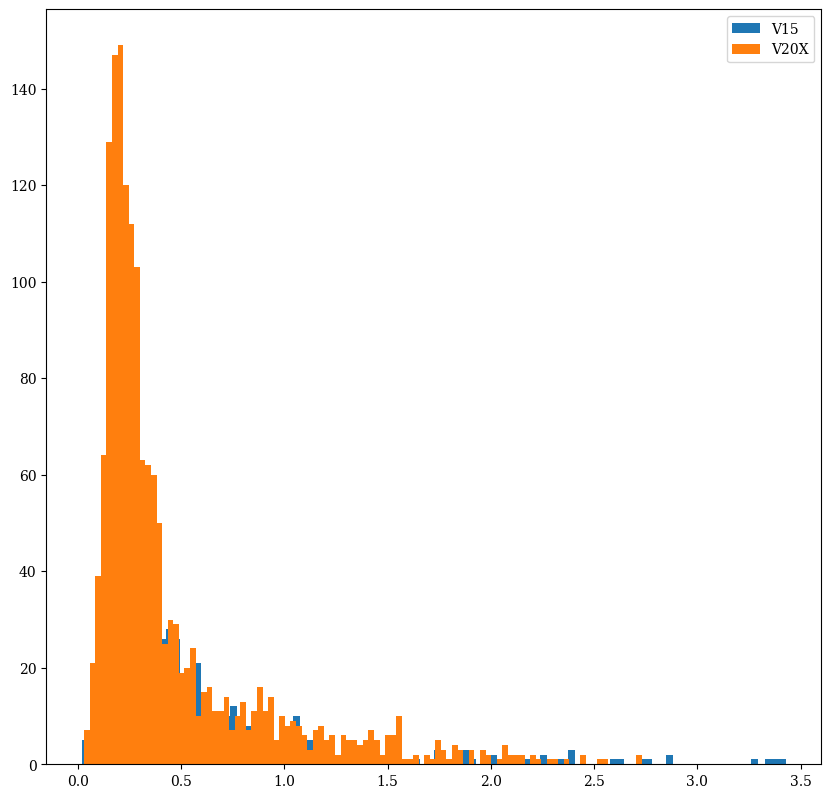

-------------------------------
Mean =  1.2546695
Median =  0.1499892771244049
Mean =  0.6506165
Median =  0.04133611172437668
delta =  -0.604053


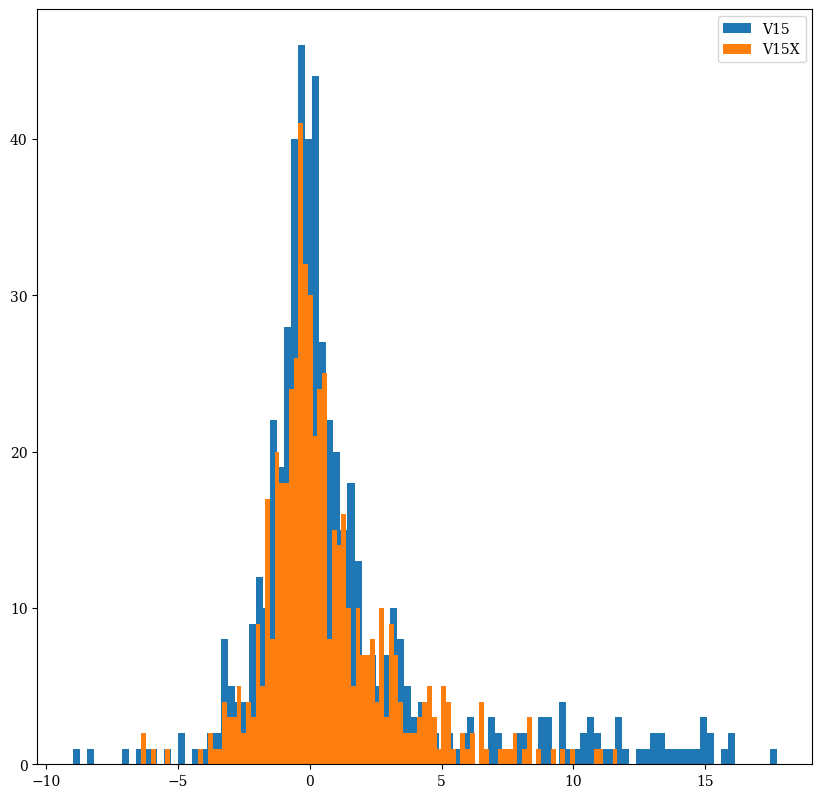

Noise plots
Mean =  0.62830234
Median =  0.44760650396347046
Mean =  0.64992493
Median =  0.43445801734924316


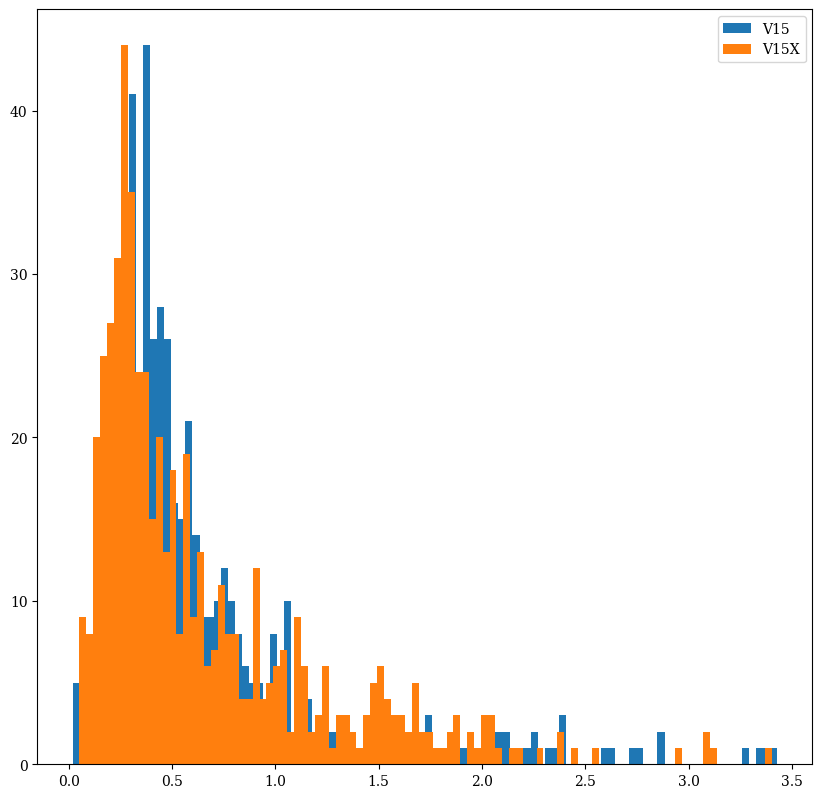

In [30]:
df_lake_groundv15 = df_V15.query(lake_ground_condition)
df_lake_groundv20 = df_V20.query(lake_ground_condition)
df_lake_groundv15X = df_V15X.query(lake_ground_condition)
df_lake_groundv20X = df_V20X.query(lake_ground_condition)


histograms_and_deltas(df_lake_groundv20,df_lake_groundv15,label="V20")
print('------------------------------')
histograms_and_deltas(df_lake_v20X,df_lake_groundv15,label="V20X")
print('-------------------------------')
histograms_and_deltas(df_lake_groundv15X,df_lake_groundv15,label="V15X")

# Vegetation

Mean =  0.28785834
Median =  0.06429769843816757
Mean =  0.60789144
Median =  0.1548408567905426
delta =  0.3200331


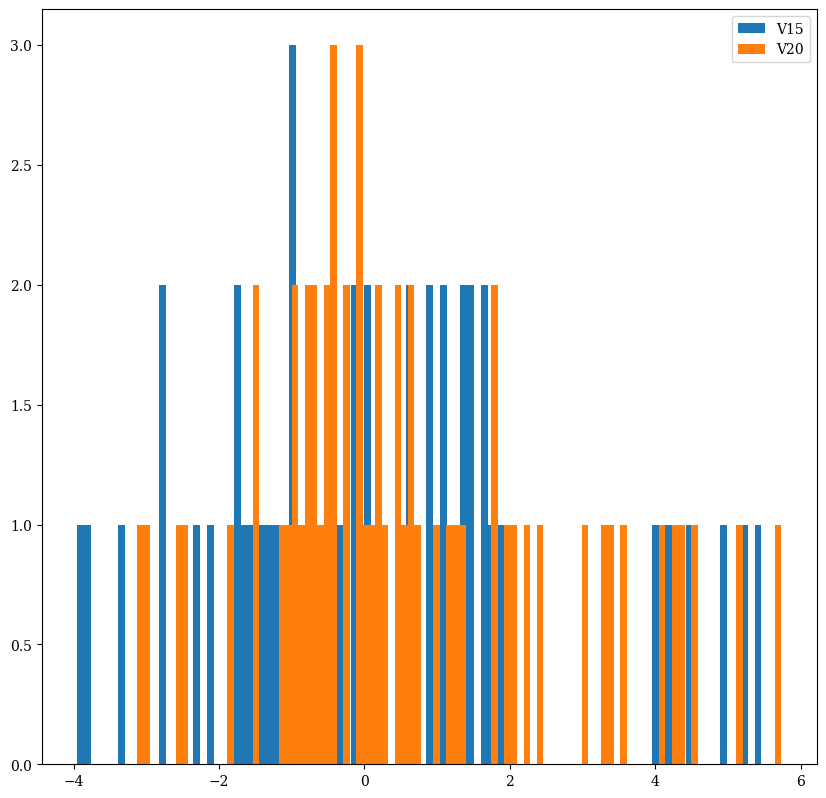

Noise plots
Mean =  0.7813524
Median =  0.6775778532028198
Mean =  1.3058136
Median =  1.0314170122146606


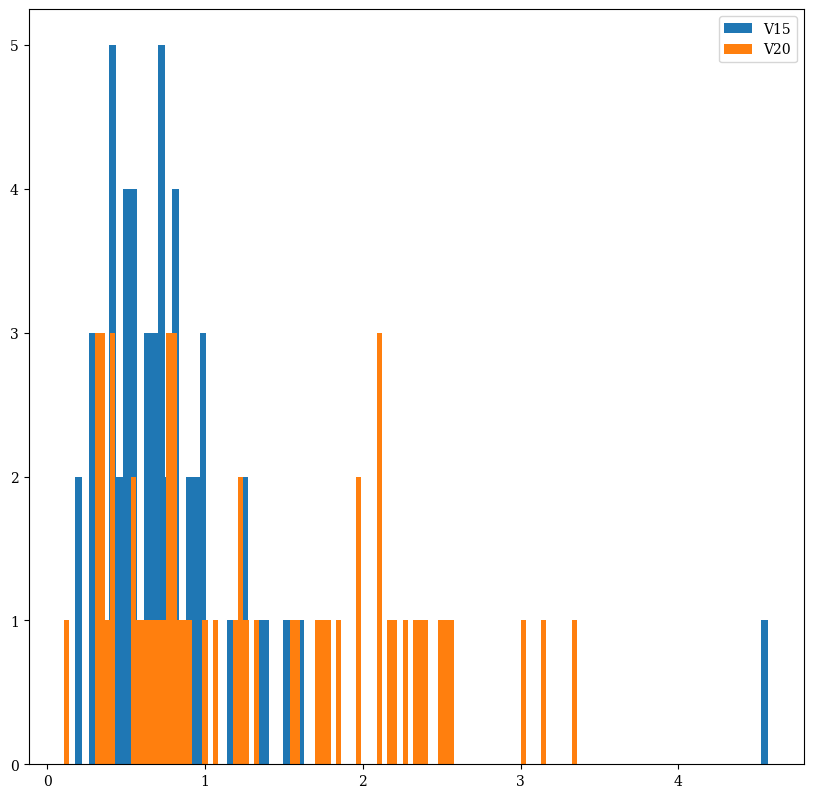

------------------------------
Mean =  0.28785834
Median =  0.06429769843816757
Mean =  0.58376306
Median =  0.16430234909057617
delta =  0.29590473


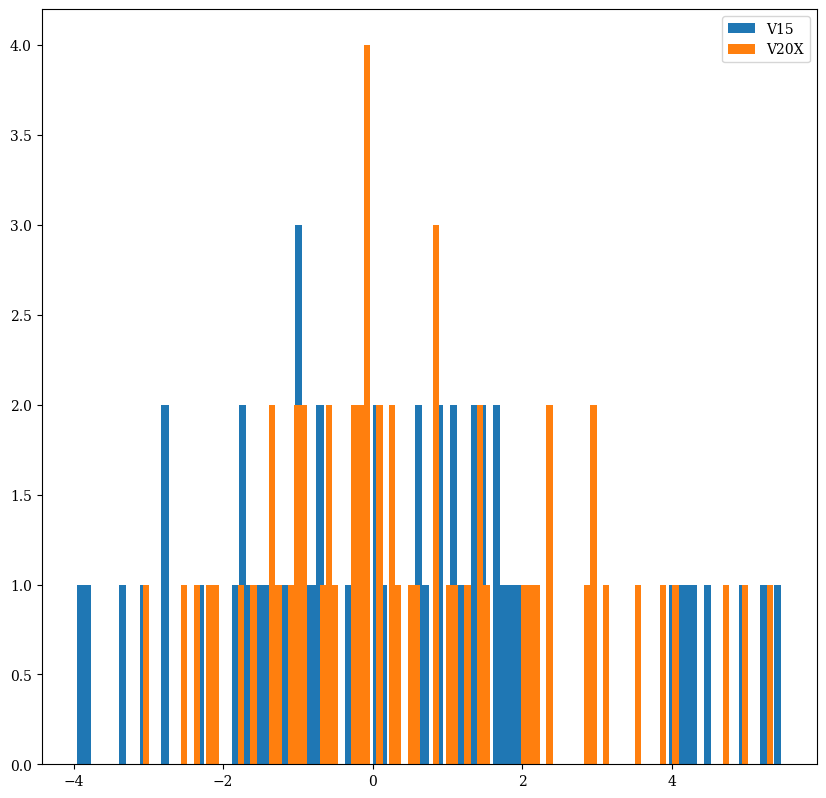

Noise plots
Mean =  0.7813524
Median =  0.6775778532028198
Mean =  1.2656146
Median =  1.0850696563720703


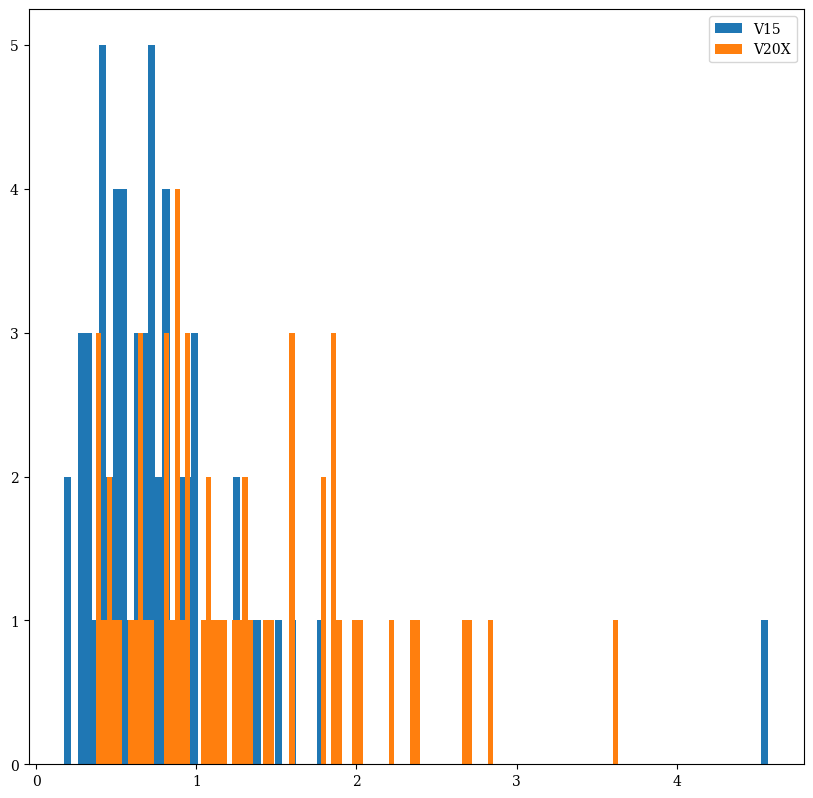

-------------------------------
Mean =  0.28785834
Median =  0.06429769843816757
Mean =  0.3241337
Median =  0.1559121310710907
delta =  0.036275357


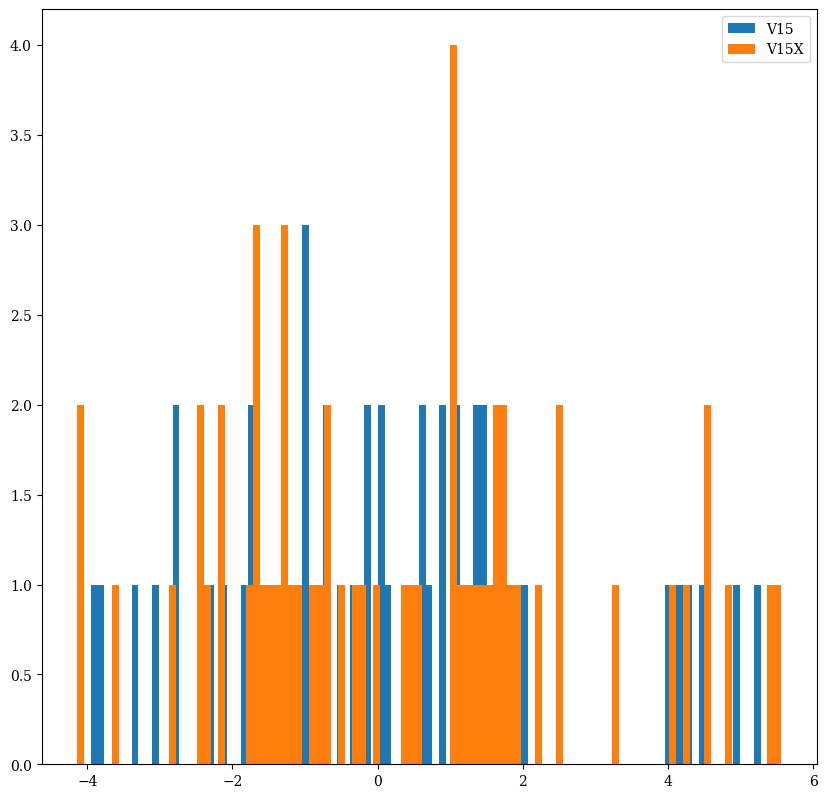

Noise plots
Mean =  0.7813524
Median =  0.6775778532028198
Mean =  0.686719
Median =  0.6369418501853943


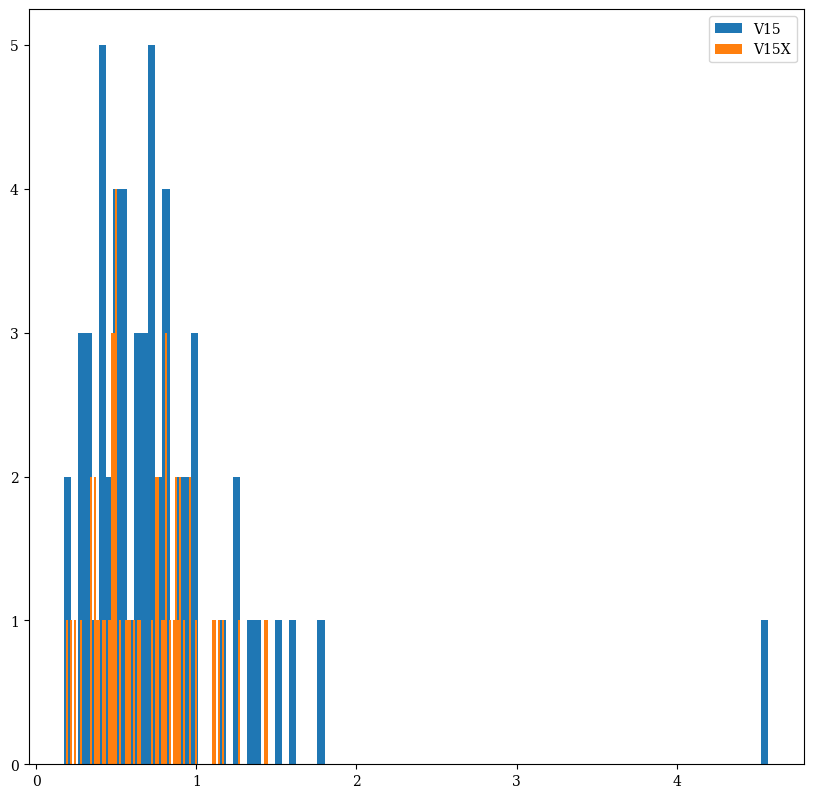

In [31]:
df_veg_v15 = df_V15.query(vegetation_condition)
df_veg_v20 = df_V20.query(vegetation_condition)
df_veg_v15X = df_V15X.query(vegetation_condition)
df_veg_v20X = df_V20X.query(vegetation_condition)


histograms_and_deltas(df_veg_v20,df_veg_v15,label="V20")
print('------------------------------')
histograms_and_deltas(df_veg_v20X,df_veg_v15,label="V20X")
print('-------------------------------')
histograms_and_deltas(df_veg_v15X,df_veg_v15,label="V15X")

# Glacier

Mean =  -0.6009369
Median =  -0.5082815885543823
Mean =  -0.19272429
Median =  -0.17059612274169922
delta =  0.4082126


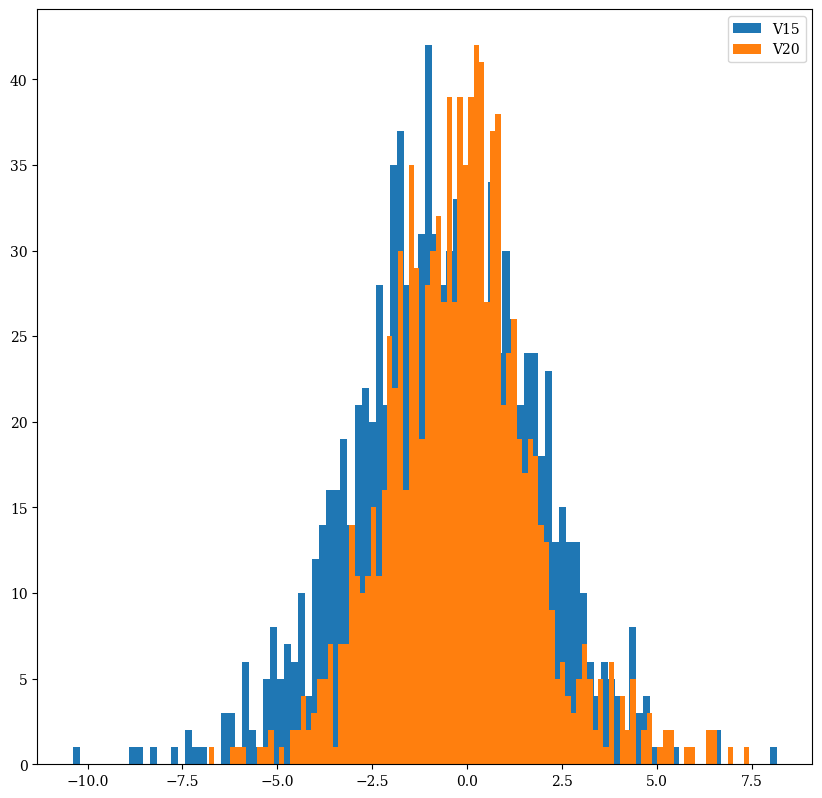

Noise plots
Mean =  0.80614805
Median =  0.7038503885269165
Mean =  0.931141
Median =  0.8272268176078796


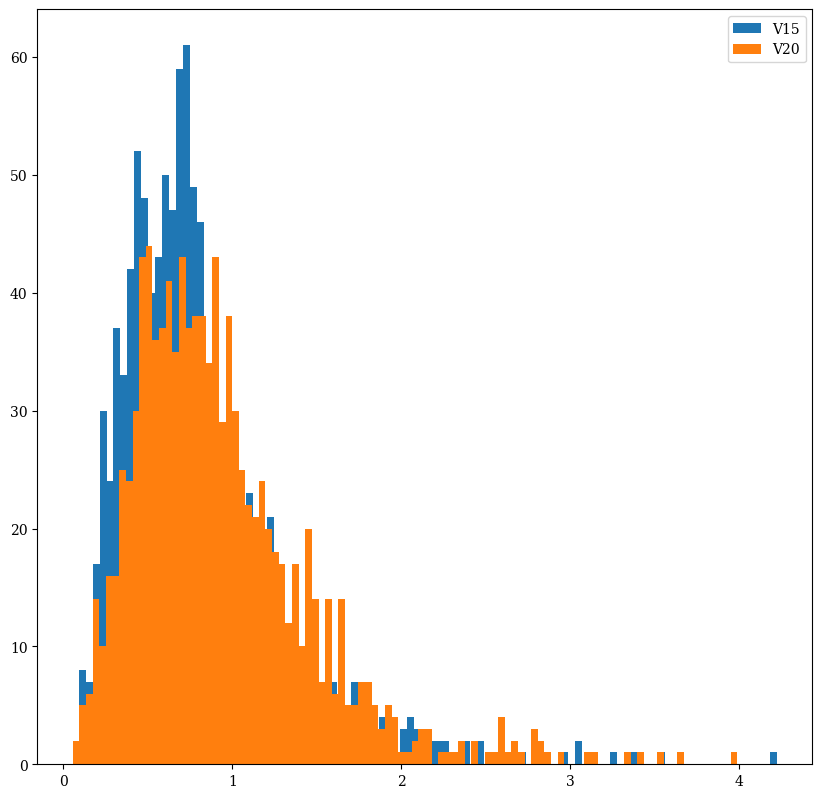

------------------------------
Mean =  -0.6009369
Median =  -0.5082815885543823
Mean =  -0.28146008
Median =  -0.2430722415447235
delta =  0.3194768


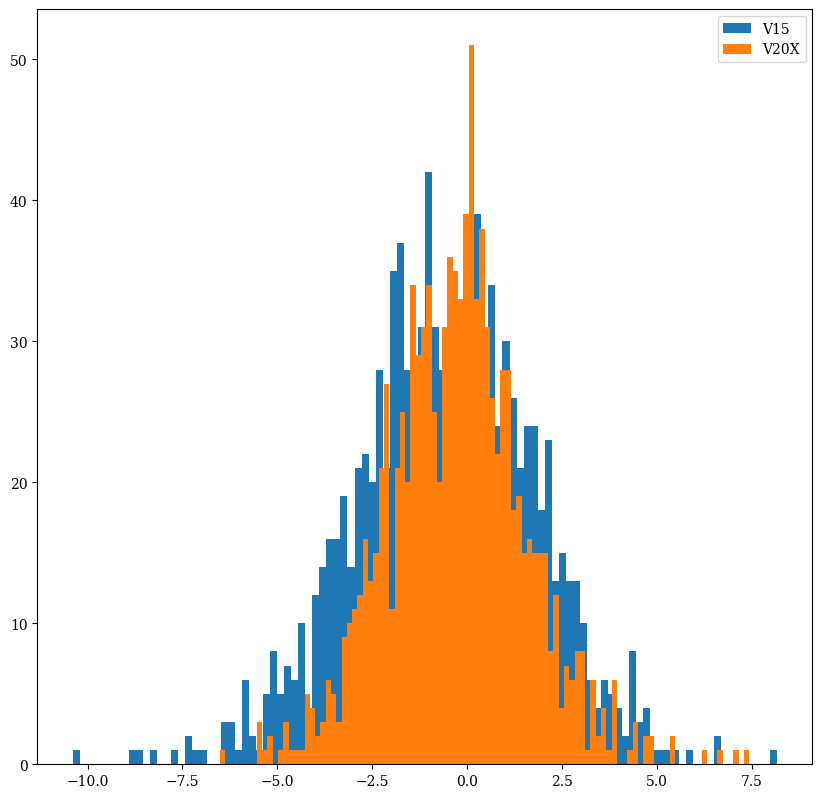

Noise plots
Mean =  0.80614805
Median =  0.7038503885269165
Mean =  0.886994
Median =  0.7901093363761902


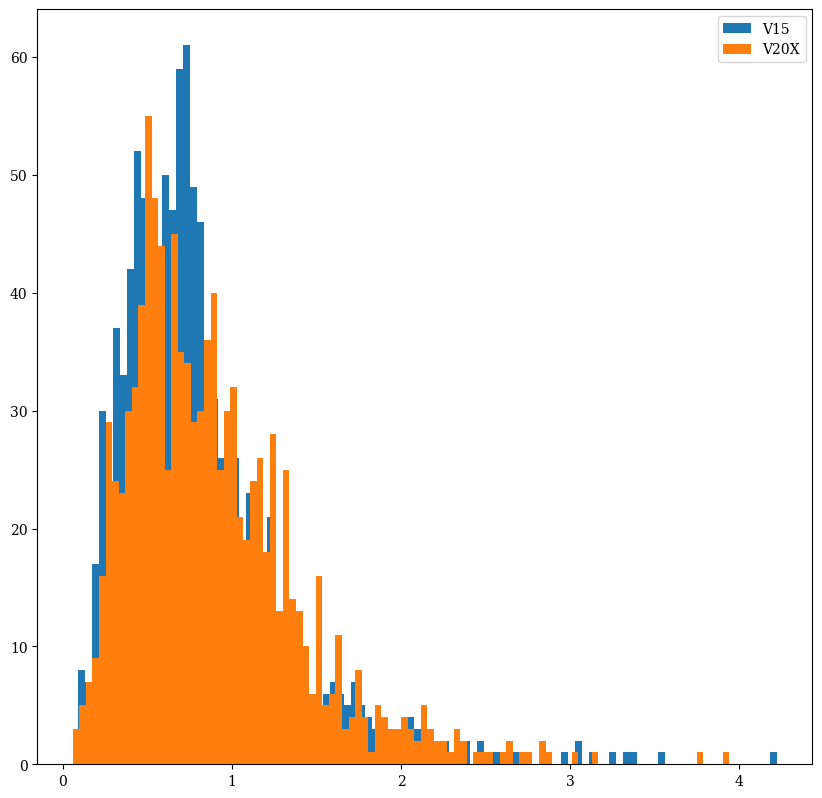

-------------------------------
Mean =  -0.6009369
Median =  -0.5082815885543823
Mean =  -0.75357157
Median =  -0.722378671169281
delta =  -0.15263468


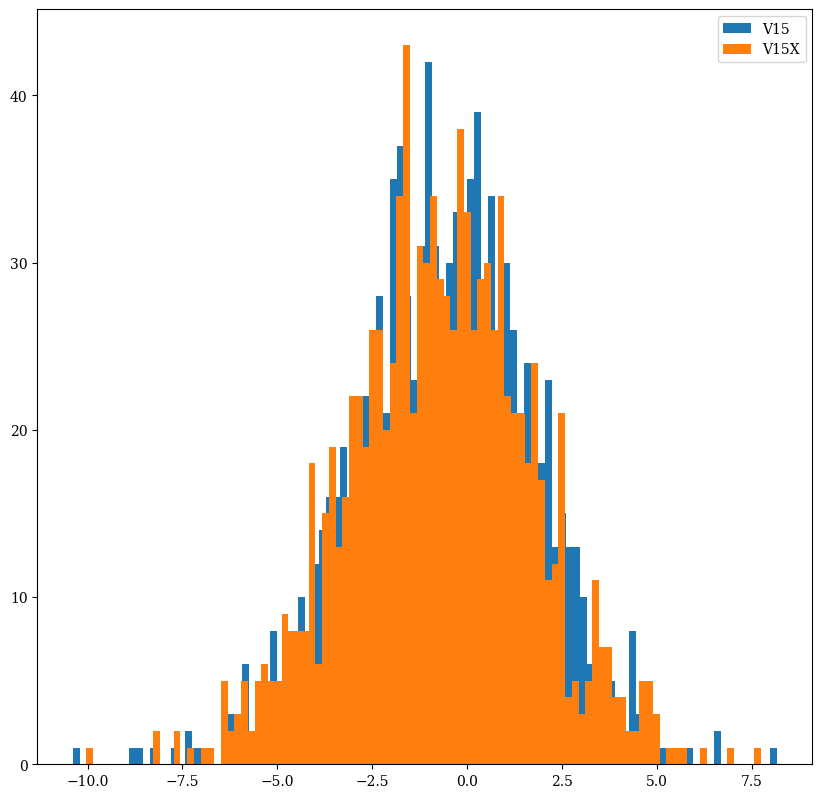

Noise plots
Mean =  0.80614805
Median =  0.7038503885269165
Mean =  0.85343707
Median =  0.7614009976387024


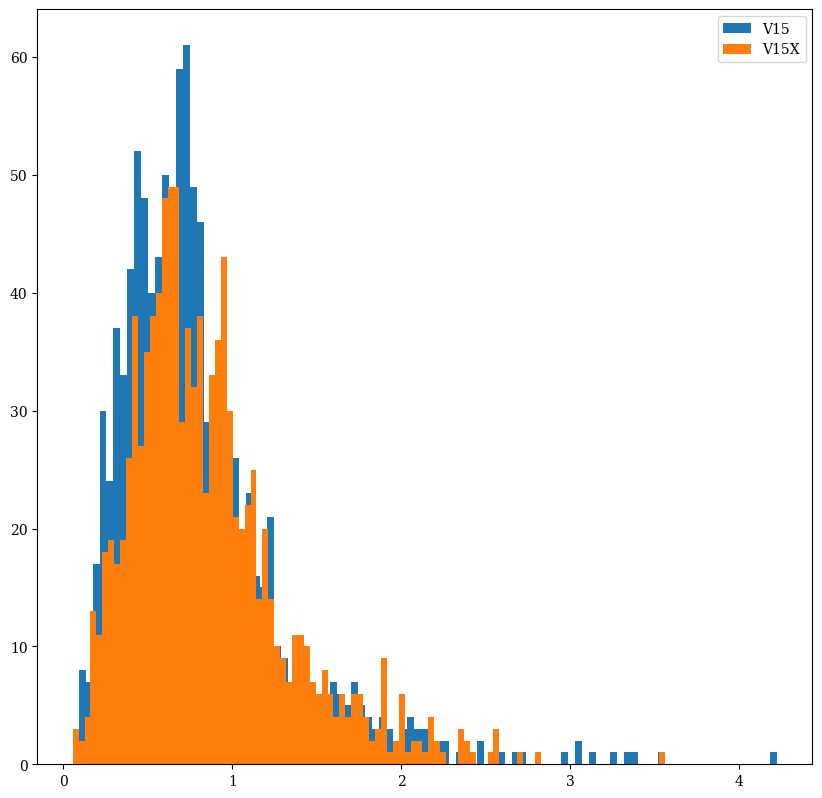

In [32]:
df_glacier_v15 = df_V15.query(glacier_condition)
df_glacier_v20 = df_V20.query(glacier_condition)
df_glacier_v15X = df_V15X.query(glacier_condition)
df_glacier_v20X = df_V20X.query(glacier_condition)


histograms_and_deltas(df_glacier_v20,df_glacier_v15,label="V20")
print('------------------------------')
histograms_and_deltas(df_glacier_v20X,df_glacier_v15,label="V20X")
print('-------------------------------')
histograms_and_deltas(df_glacier_v15X,df_glacier_v15,label="V15X")

#### Deep dive on individual bad points

In [33]:
df_lake = pd.concat([df_lake_v15,df_lake_v20,df_lake_v15X,df_lake_v20X])
df_glacier = pd.concat([df_glacier_v15,df_glacier_v20,df_glacier_v15X,df_glacier_v20X])

In [34]:
lake_natron = df_lake.query('latitude_ERA == -2.3887580539270044 & longitude_ERA == 36.0000')
lake_natron_northern_edge =df_lake.query('latitude_ERA == -2.10772769472398 & longitude_ERA == 36.0000') 
lake_blanche =df_lake.query('latitude_ERA ==  -29.367671674745356 & longitude_ERA == 139.6875') 
salt_lake_city =df_lake.query('latitude_ERA ==  41.17094491970063 & longitude_ERA ==  -113.39999999999998') 
farah_province =df_lake.query('latitude_ERA ==  31.615914311651938 & longitude_ERA == 61.120000000000005') 
gujarat_province =df_lake.query('latitude_ERA ==  24.028095261448925 & longitude_ERA ==  69.0') 
toshka_lakes =df_lake.query('latitude_ERA ==  23.18500423251539 & longitude_ERA ==  30.900000000000006') 
all_northern_canada_points = df_lake.query('50.0 < latitude_ERA & -130 < longitude_ERA < -80')

caspain_1 = df_lake.query('latitude_ERA ==  46.22948997297545 & longitude_ERA ==   49.125')
caspain_2 = df_lake.query('latitude_ERA ==  46.22948997297545 & longitude_ERA ==    49.5')
caspain_3 = df_lake.query('latitude_ERA ==  46.51052023808231 & longitude_ERA ==    49.5')
caspain_4 = df_lake.query('latitude_ERA ==  47.072580762649004 & longitude_ERA ==    51.599999999999994')

caspian_edge = pd.concat([caspain_1,caspain_2,caspain_3,caspain_4])

bering_glacier = df_glacier.query('latitude_ERA == 60.280999861571715   & longitude_ERA ==    -143.4666666666667')
juncal_glacier = df_glacier.query('latitude_ERA == -33.021065936911214   & longitude_ERA ==    -70.07999999999998')


### Lake natron

In [35]:
surface_cols = ['latitude_ERA', 'longitude_ERA','prediction_error_1','prediction_error_2','prediction_error_3','prediction_error_4','mean_error','variance','label']
display(lake_natron[surface_cols])
print("delta V20= ", lake_natron.query("label == 'V20'")['mean_error'] - lake_natron.query("label == 'V15'")['mean_error'])
print("delta V20X= ", lake_natron.query("label == 'V20X'")['mean_error'] - lake_natron.query("label == 'V15'")['mean_error'])
print("delta V15X= ", lake_natron.query("label == 'V15X'")['mean_error'] - lake_natron.query("label == 'V15'")['mean_error'])

,latitude_ERA,longitude_ERA,prediction_error_1,prediction_error_2,prediction_error_3,prediction_error_4,mean_error,variance,label
38367,-2.388758,36.0,0.665792,0.058747,-0.912324,1.172968,0.246296,0.896711,V15
38367,-2.388758,36.0,4.868020,6.836025,6.226716,4.348995,5.569939,1.157256,V20
38367,-2.388758,36.0,0.395664,3.037828,0.083954,7.354142,2.717897,3.362913,V15X
38367,-2.388758,36.0,4.782181,5.434520,5.460616,6.590699,5.567004,0.751170,V20X


delta V20=  38367    5.323644
Name: mean_error, dtype: float32
delta V20X=  38367    5.320708
Name: mean_error, dtype: float32
delta V15X=  38367    2.471601
Name: mean_error, dtype: float32


### Lake natron, northern edge

In [36]:
surface_cols = ['latitude_ERA', 'longitude_ERA','prediction_error_1','prediction_error_2','prediction_error_3','prediction_error_4','mean_error','variance','label']
display(lake_natron_northern_edge[surface_cols])
print("delta V20= ", lake_natron_northern_edge.query("label == 'V20'")['mean_error'] - lake_natron_northern_edge.query("label == 'V15'")['mean_error'])
print("delta V20X= ", lake_natron_northern_edge.query("label == 'V20X'")['mean_error'] - lake_natron_northern_edge.query("label == 'V15'")['mean_error'])
print("delta V15X= ", lake_natron_northern_edge.query("label == 'V15X'")['mean_error'] - lake_natron_northern_edge.query("label == 'V15'")['mean_error'])

,latitude_ERA,longitude_ERA,prediction_error_1,prediction_error_2,prediction_error_3,prediction_error_4,mean_error,variance,label
38705,-2.107728,36.0,-0.255241,0.943548,-0.495419,-0.616830,-0.105985,0.715639,V15
38705,-2.107728,36.0,4.574685,4.173297,3.897568,2.599977,3.811382,0.854116,V20
38705,-2.107728,36.0,3.107937,1.613332,0.516025,3.064965,2.075565,1.250404,V15X
38705,-2.107728,36.0,3.077464,3.026988,3.580766,3.524926,3.302536,0.290662,V20X


delta V20=  38705    3.917367
Name: mean_error, dtype: float32
delta V20X=  38705    3.408521
Name: mean_error, dtype: float32
delta V15X=  38705    2.18155
Name: mean_error, dtype: float32


### Lake Blanche

In [37]:
display(lake_blanche[surface_cols])
print("delta V20= ", lake_blanche.query("label == 'V20'")['mean_error'] - lake_blanche.query("label == 'V15'")['mean_error'])
print("delta V20X= ", lake_blanche.query("label == 'V20X'")['mean_error'] - lake_blanche.query("label == 'V15'")['mean_error'])
print("delta V15X= ", lake_blanche.query("label == 'V15X'")['mean_error'] - lake_blanche.query("label == 'V15'")['mean_error'])

,latitude_ERA,longitude_ERA,prediction_error_1,prediction_error_2,prediction_error_3,prediction_error_4,mean_error,variance,label
9220,-29.367672,139.6875,-0.988965,0.453567,1.471866,4.364192,1.325165,2.263632,V15
9220,-29.367672,139.6875,0.087244,-6.299630,-2.359139,-0.591668,-2.290798,2.864584,V20
9220,-29.367672,139.6875,-0.752034,0.786616,-0.145554,3.922448,0.952869,2.078402,V15X
9220,-29.367672,139.6875,-1.580488,-0.575642,0.716229,1.021339,-0.104641,1.203000,V20X


delta V20=  9220   -3.615963
Name: mean_error, dtype: float32
delta V20X=  9220   -1.429806
Name: mean_error, dtype: float32
delta V15X=  9220   -0.372296
Name: mean_error, dtype: float32


### Salt lake city

In [38]:
display(salt_lake_city[surface_cols])
print("delta V20= ", salt_lake_city.query("label == 'V20'")['mean_error'] - salt_lake_city.query("label == 'V15'")['mean_error'])
print("delta V20X= ", salt_lake_city.query("label == 'V20X'")['mean_error'] - salt_lake_city.query("label == 'V15'")['mean_error'])
print("delta V15X= ", salt_lake_city.query("label == 'V15X'")['mean_error'] - salt_lake_city.query("label == 'V15'")['mean_error'])

,latitude_ERA,longitude_ERA,prediction_error_1,prediction_error_2,prediction_error_3,prediction_error_4,mean_error,variance,label
101073,41.170945,-113.4,-1.529864,2.244767,3.987374,0.937279,1.409889,2.324217,V15
101073,41.170945,-113.4,-6.589550,-5.147917,-3.943223,-5.314858,-5.248887,1.082695,V20
101073,41.170945,-113.4,-1.736709,-2.208952,1.152817,0.282978,-0.627467,1.605183,V15X
101073,41.170945,-113.4,-2.977890,0.099614,-3.097751,-2.936324,-2.228088,1.553310,V20X


delta V20=  101073   -6.658776
Name: mean_error, dtype: float32
delta V20X=  101073   -3.637977
Name: mean_error, dtype: float32
delta V15X=  101073   -2.037356
Name: mean_error, dtype: float32


### Farah province

In [39]:
display(farah_province[surface_cols])
print("delta V20= ", farah_province.query("label == 'V20'")['mean_error'] - farah_province.query("label == 'V15'")['mean_error'])
print("delta V20X= ", farah_province.query("label == 'V20X'")['mean_error'] - farah_province.query("label == 'V15'")['mean_error'])
print("delta V15X= ", farah_province.query("label == 'V15X'")['mean_error'] - farah_province.query("label == 'V15'")['mean_error'])

,latitude_ERA,longitude_ERA,prediction_error_1,prediction_error_2,prediction_error_3,prediction_error_4,mean_error,variance,label
84857,31.615914,61.12,-0.821299,-0.654317,-0.429189,-0.995950,-0.725189,0.241653,V15
84857,31.615914,61.12,-1.292352,-1.984526,-1.512960,-1.752055,-1.635473,0.298982,V20
84857,31.615914,61.12,0.423816,1.244860,1.114781,0.341954,0.781353,0.464370,V15X
84857,31.615914,61.12,0.089828,0.289069,-0.373947,-1.799484,-0.448633,0.942430,V20X


delta V20=  84857   -0.910285
Name: mean_error, dtype: float32
delta V20X=  84857    0.276555
Name: mean_error, dtype: float32
delta V15X=  84857    1.506541
Name: mean_error, dtype: float32


### Gujarat, India

In [40]:
display(gujarat_province[surface_cols])
print("delta V20= ", gujarat_province.query("label == 'V20'")['mean_error'] - gujarat_province.query("label == 'V15'")['mean_error'])
print("delta V20X= ", gujarat_province.query("label == 'V20X'")['mean_error'] - gujarat_province.query("label == 'V15'")['mean_error'])
print("delta V15X= ", gujarat_province.query("label == 'V15X'")['mean_error'] - gujarat_province.query("label == 'V15'")['mean_error'])

,latitude_ERA,longitude_ERA,prediction_error_1,prediction_error_2,prediction_error_3,prediction_error_4,mean_error,variance,label
71526,24.028095,69.0,4.524725,4.093192,11.083893,4.346132,6.011985,3.385903,V15
71526,24.028095,69.0,10.477352,10.972689,11.598255,10.654816,10.925777,0.492927,V20
71526,24.028095,69.0,-0.095474,5.086374,3.363923,6.809064,3.790972,2.948094,V15X
71526,24.028095,69.0,11.347068,13.798063,11.184633,11.568027,11.974448,1.225855,V20X


delta V20=  71526    4.913792
Name: mean_error, dtype: float32
delta V20X=  71526    5.962463
Name: mean_error, dtype: float32
delta V15X=  71526   -2.221014
Name: mean_error, dtype: float32


### Toshka lakes

In [41]:
display(toshka_lakes[surface_cols])
print("delta V20= ", toshka_lakes.query("label == 'V20'")['mean_error'] - toshka_lakes.query("label == 'V15'")['mean_error'])
print("delta V20X= ", toshka_lakes.query("label == 'V20X'")['mean_error'] - toshka_lakes.query("label == 'V15'")['mean_error'])
print("delta V15X= ", toshka_lakes.query("label == 'V15X'")['mean_error'] - toshka_lakes.query("label == 'V15'")['mean_error'])

,latitude_ERA,longitude_ERA,prediction_error_1,prediction_error_2,prediction_error_3,prediction_error_4,mean_error,variance,label
70081,23.185004,30.9,1.667985,3.682419,1.315017,4.408886,2.768577,1.511055,V15
70081,23.185004,30.9,0.662095,-0.915258,-0.162041,1.722857,0.326913,1.131823,V20
70081,23.185004,30.9,1.128407,2.587530,2.403831,1.867690,1.996864,0.654577,V15X
70081,23.185004,30.9,-2.145674,-0.483359,-0.078945,0.193752,-0.628556,1.048967,V20X


delta V20=  70081   -2.441664
Name: mean_error, dtype: float32
delta V20X=  70081   -3.397134
Name: mean_error, dtype: float32
delta V15X=  70081   -0.771713
Name: mean_error, dtype: float32


### Northern Canada

,latitude_ERA,longitude_ERA,prediction_error_1,prediction_error_2,prediction_error_3,prediction_error_4,mean_error,variance,label
122282,52.693186,-126.900000,-1.129708,-0.918603,-1.342583,-0.339880,-0.932693,0.431451,V15
123852,53.536276,-112.500000,0.321896,0.527130,0.609163,-0.240235,0.304488,0.382719,V15
123919,53.536276,-82.350000,0.724677,-0.048612,-0.191533,0.499172,0.245926,0.436447,V15
131064,58.032759,-94.000000,-0.037011,0.291870,0.433978,-0.362784,0.081513,0.355870,V15
134032,59.999970,-95.466667,0.208771,0.417150,0.776497,-0.673347,0.182268,0.616727,V15
...,...,...,...,...,...,...,...,...,...
149569,70.117048,-101.250000,-2.591525,-0.437551,-1.212552,-0.222613,-1.116060,1.071592,V20X
149571,70.117048,-96.000000,-0.869053,-1.254500,-0.841681,-1.269816,-1.058762,0.235210,V20X
149572,70.117048,-95.250000,-0.156646,-0.560008,-0.328023,-0.644367,-0.422261,0.221914,V20X
149575,70.117048,-93.000000,-0.525648,-0.720946,-0.653071,-0.644812,-0.636119,0.081163,V20X


Mean =  -0.43733183
Median =  -0.38143405318260193
Mean =  -0.14902304
Median =  -0.0655197948217392
delta =  0.2883088


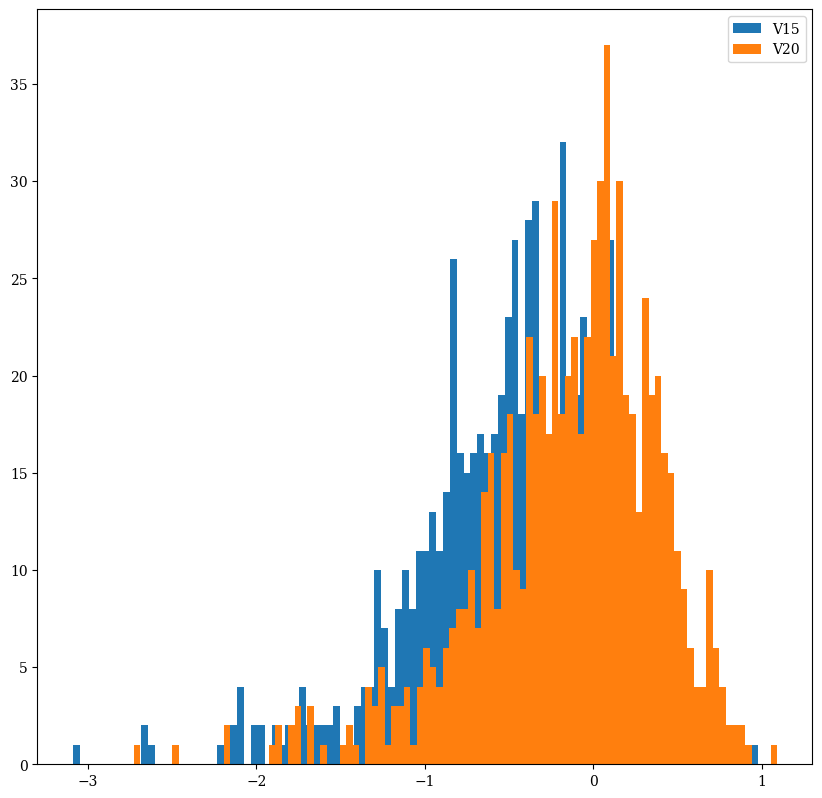

Noise plots
Mean =  0.24704875
Median =  0.22770996391773224
Mean =  0.1636214
Median =  0.13315647840499878


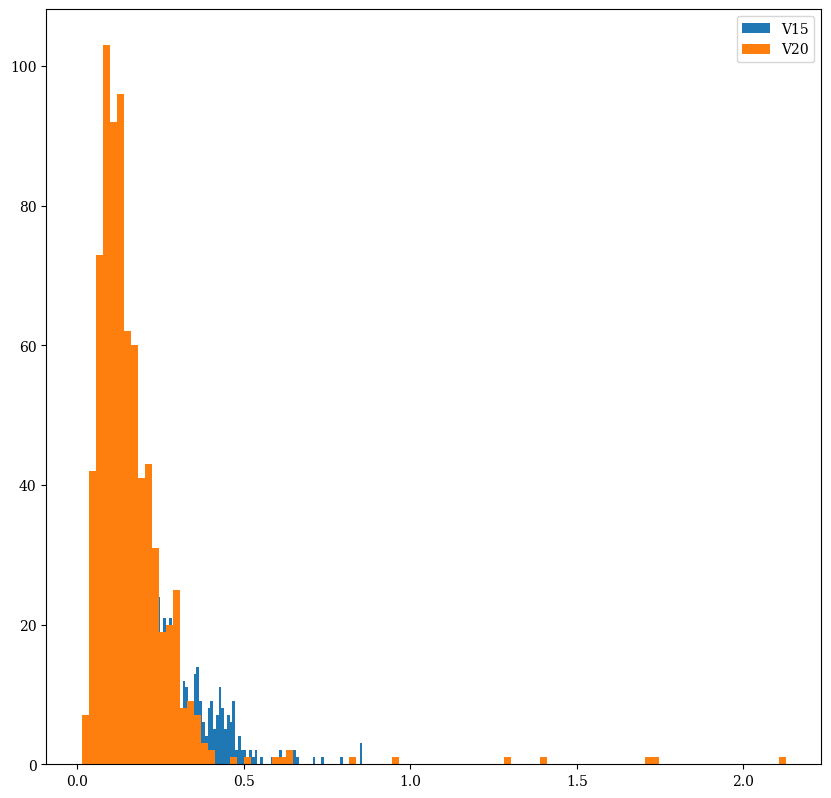

------------------------------
Mean =  -0.43733183
Median =  -0.38143405318260193
Mean =  -0.18892357
Median =  -0.11761028319597244
delta =  0.24840826


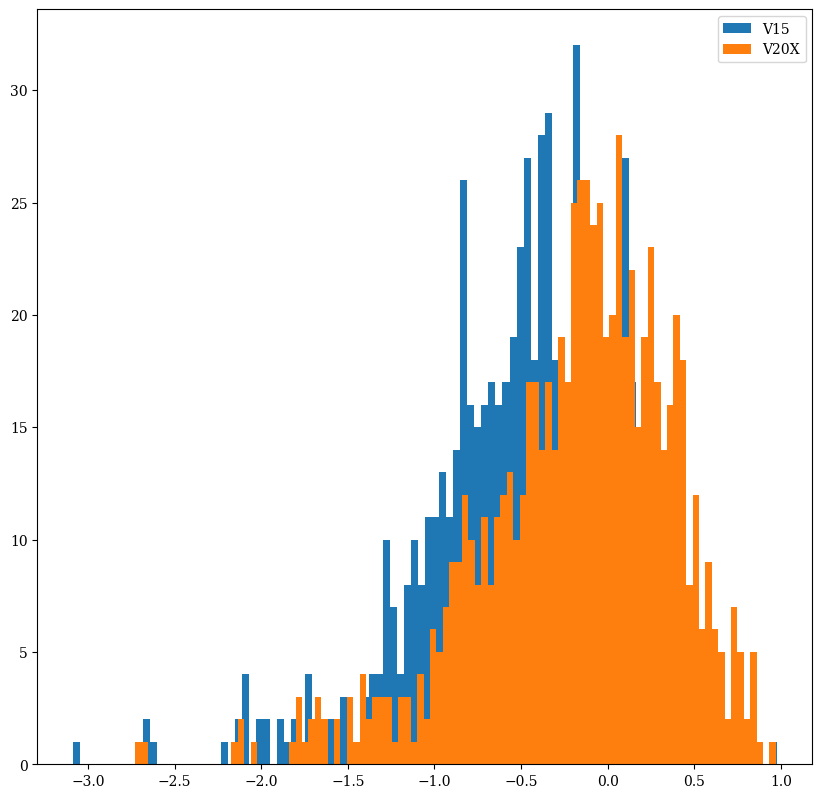

Noise plots
Mean =  0.24704875
Median =  0.22770996391773224
Mean =  0.23853269
Median =  0.21333378553390503


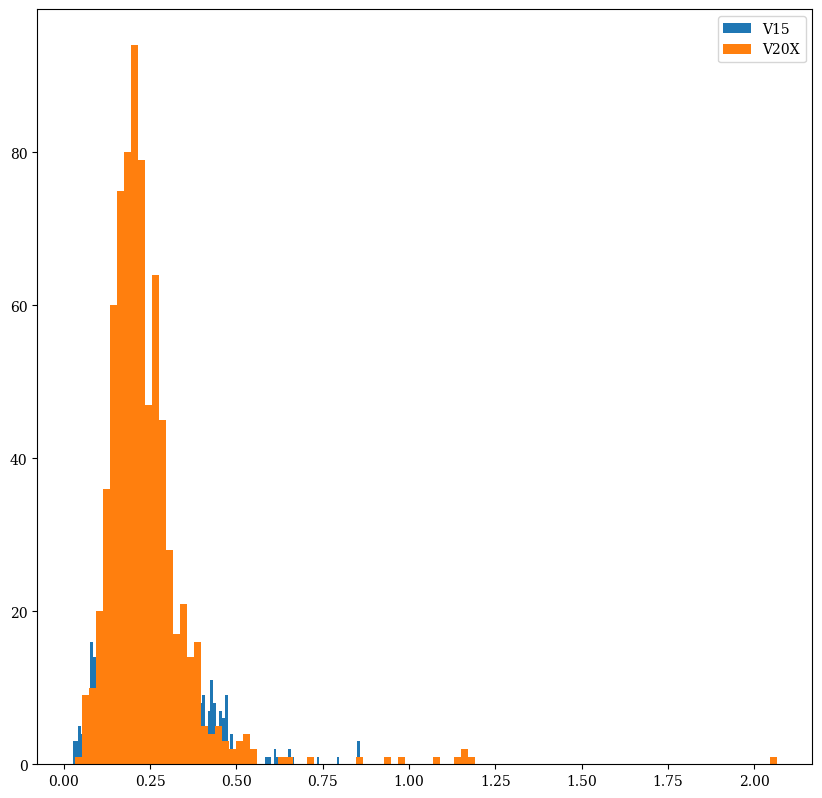

-------------------------------
Mean =  -0.43733183
Median =  -0.38143405318260193
Mean =  -0.40234932
Median =  -0.3542224168777466
delta =  0.034982502


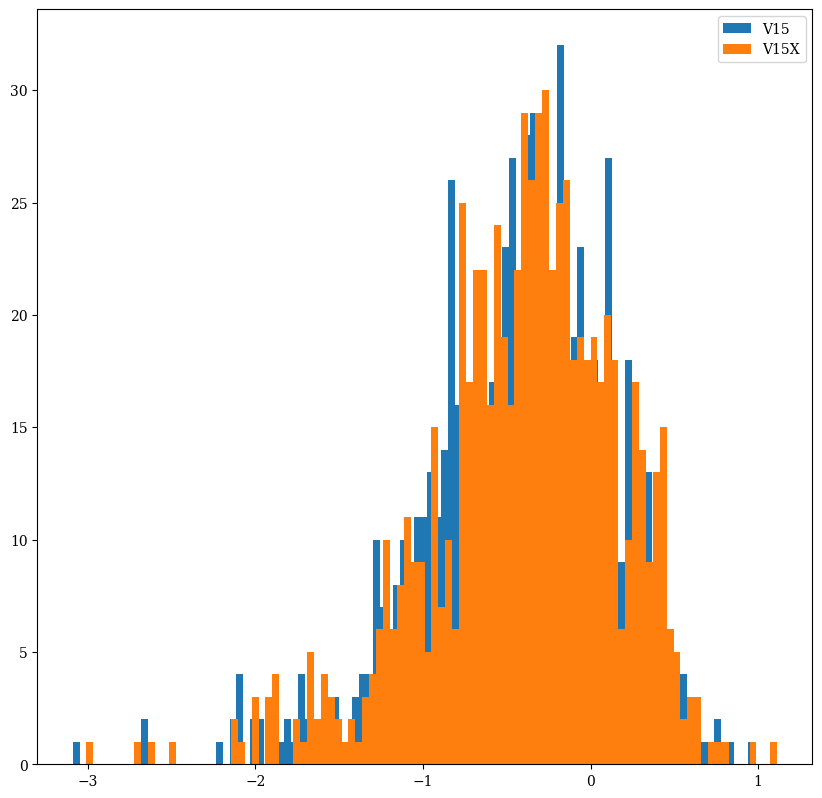

Noise plots
Mean =  0.24704875
Median =  0.22770996391773224
Mean =  0.21476518
Median =  0.1958611011505127


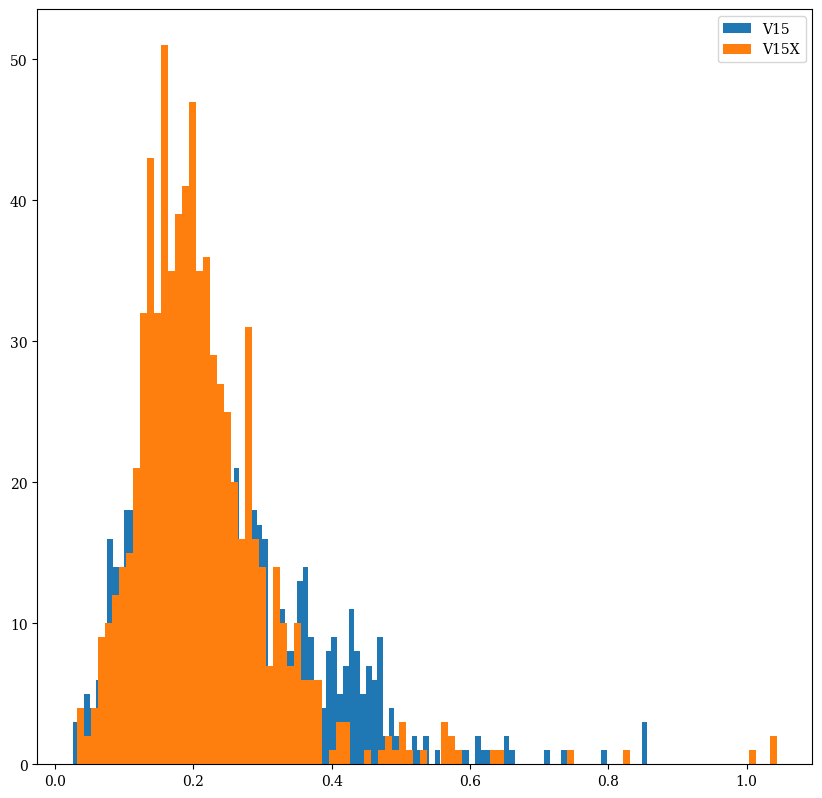

In [42]:


display(all_northern_canada_points[surface_cols])



histograms_and_deltas(all_northern_canada_points.query("label == 'V20'"),all_northern_canada_points.query("label == 'V15'"),label="V20")
print('------------------------------')
histograms_and_deltas(all_northern_canada_points.query("label == 'V20X'"),all_northern_canada_points.query("label == 'V15'"),label="V20X")
print('-------------------------------')
histograms_and_deltas(all_northern_canada_points.query("label == 'V15X'"),all_northern_canada_points.query("label == 'V15'"),label="V15X")







### Caspian

,latitude_ERA,longitude_ERA,prediction_error_1,prediction_error_2,prediction_error_3,prediction_error_4,mean_error,variance,label
110440,46.229490,49.125,-1.980254,-1.786134,-1.972023,-1.642567,-1.845245,0.162144,V15
110440,46.229490,49.125,-2.108013,-3.780375,-0.921914,1.187896,-1.405602,2.089108,V20
110440,46.229490,49.125,-2.004888,-1.521075,-1.771783,-2.253401,-1.887787,0.313752,V15X
110440,46.229490,49.125,-2.123799,-1.704057,-1.996190,-2.536355,-2.090100,0.345508,V20X
110441,46.229490,49.500,-0.861195,0.028180,-0.238950,0.550257,-0.130427,0.587164,V15
110441,46.229490,49.500,-0.965258,-1.311271,-0.693714,0.020157,-0.737522,0.564815,V20
110441,46.229490,49.500,-0.704145,-1.837399,-0.380053,-2.567661,-1.372315,1.012619,V15X
110441,46.229490,49.500,-0.739498,-0.531446,-0.805137,-0.915461,-0.747886,0.161530,V20X
110991,46.510520,49.500,2.414944,2.700470,3.241919,2.680512,2.759461,0.346973,V15
110991,46.510520,49.500,2.604385,2.009253,2.684987,2.901664,2.550072,0.381774,V20


Mean =  0.6377959
Median =  0.8184835314750671
Mean =  0.61021054
Median =  0.6481856107711792
delta =  -0.027585387


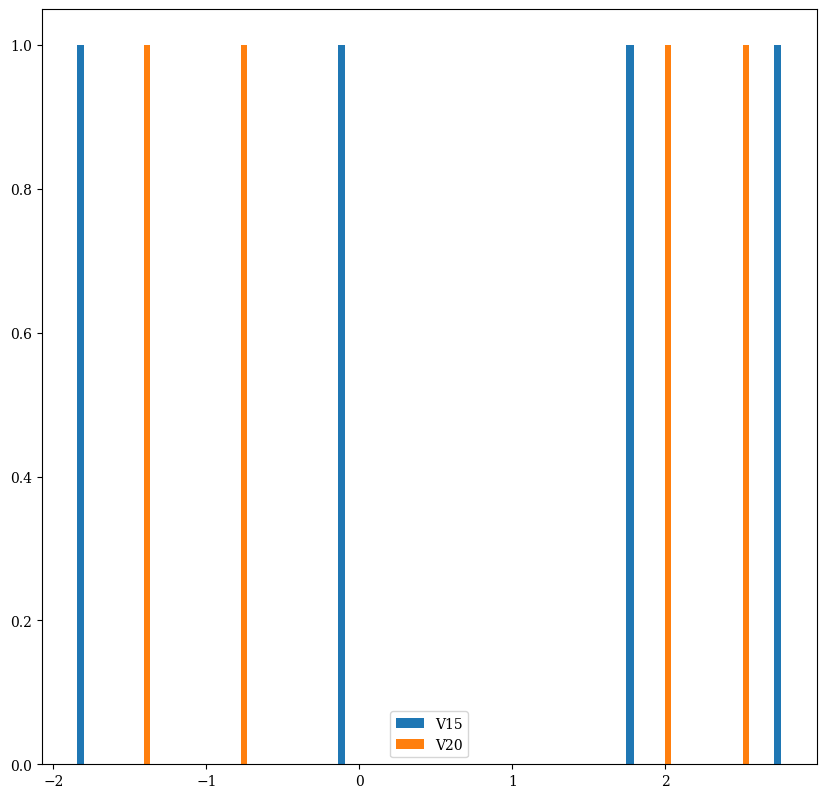

Noise plots
Mean =  0.41806155
Median =  0.46146872639656067
Mean =  0.88898563
Median =  0.5425302982330322


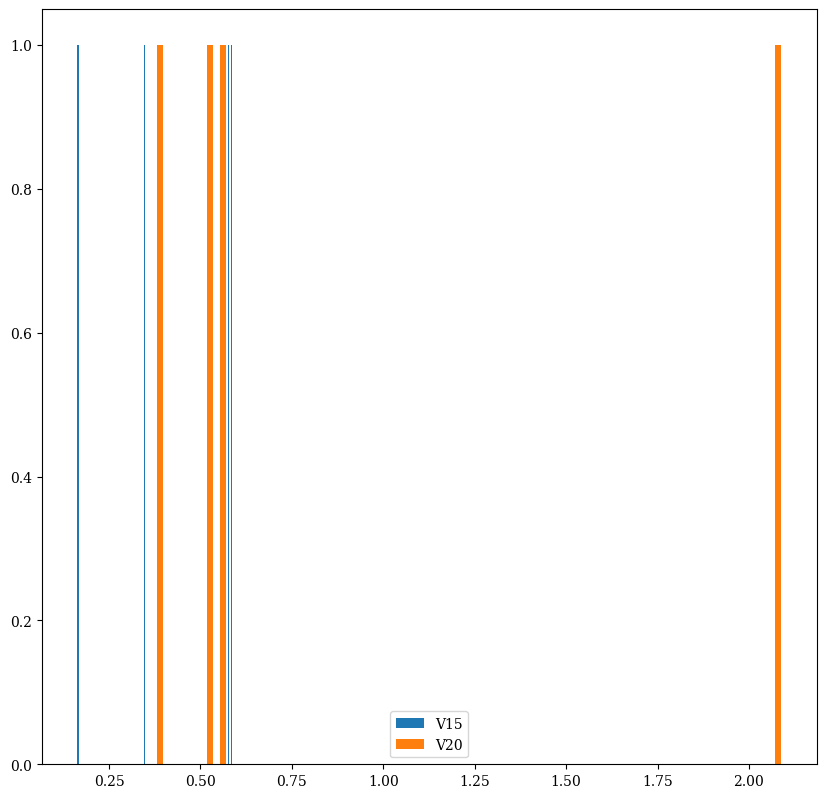

------------------------------
Mean =  0.6377959
Median =  0.8184835314750671
Mean =  0.2007305
Median =  0.34196844696998596
delta =  -0.43706542


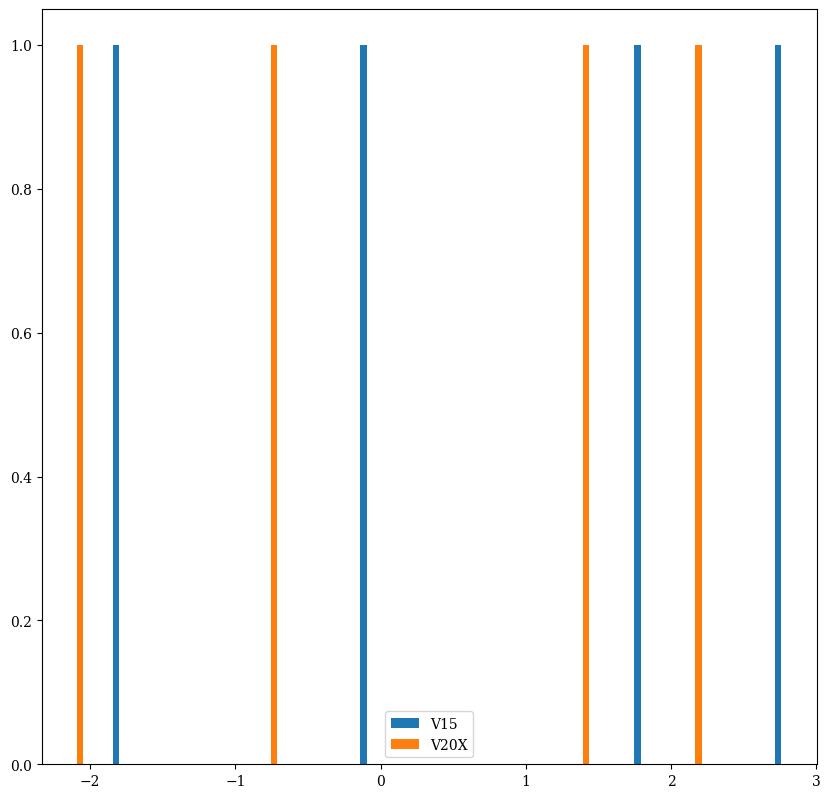

Noise plots
Mean =  0.41806155
Median =  0.46146872639656067
Mean =  0.46773154
Median =  0.3719913363456726


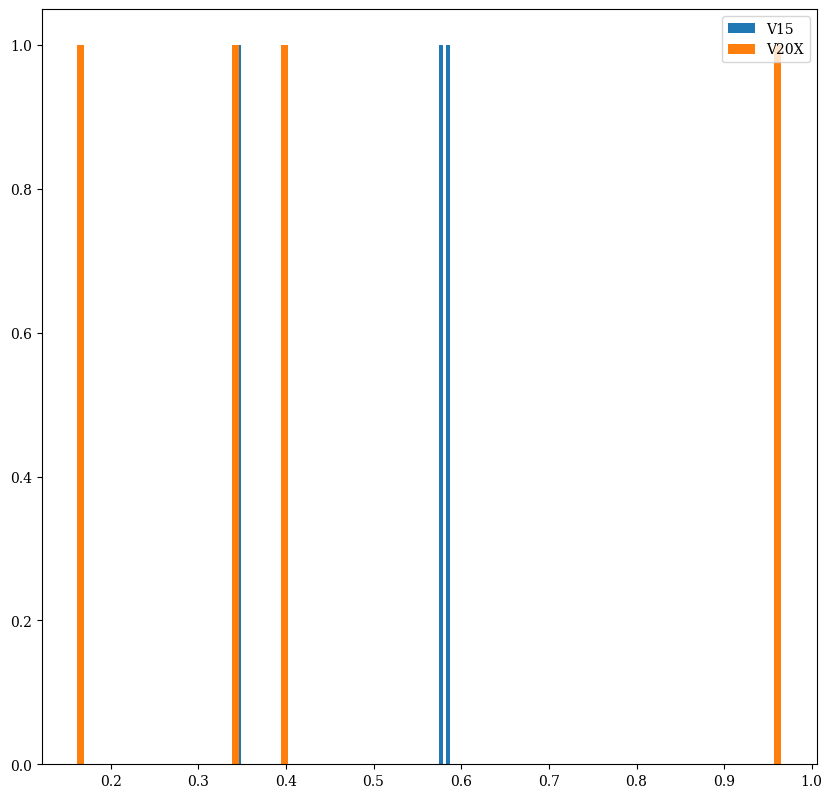

-------------------------------
Mean =  0.6377959
Median =  0.8184835314750671
Mean =  0.15514308
Median =  0.10958391427993774
delta =  -0.48265284


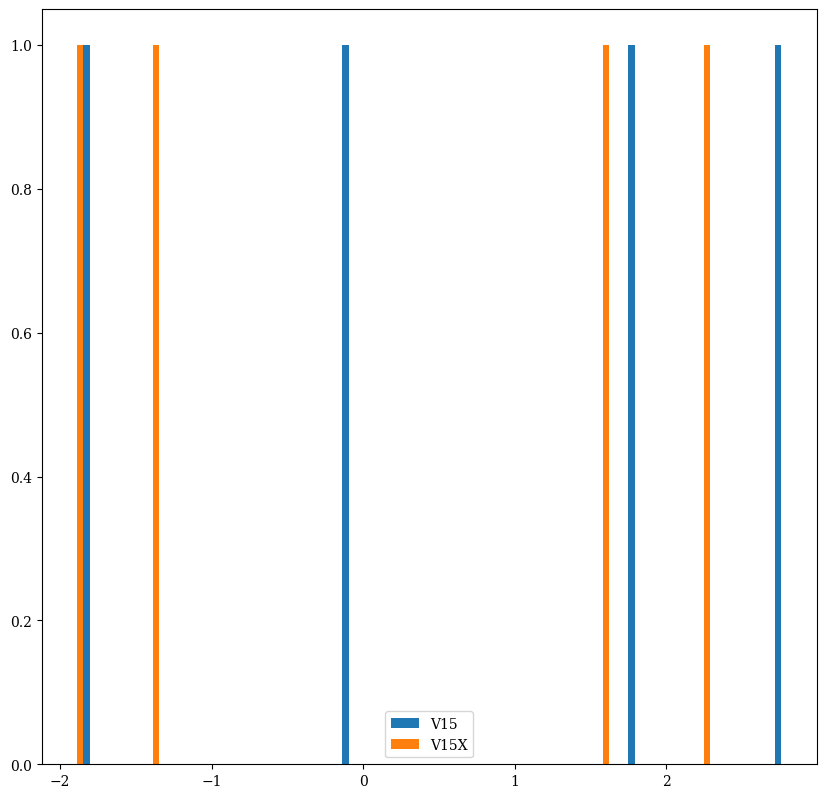

Noise plots
Mean =  0.41806155
Median =  0.46146872639656067
Mean =  0.6728326
Median =  0.6824798583984375


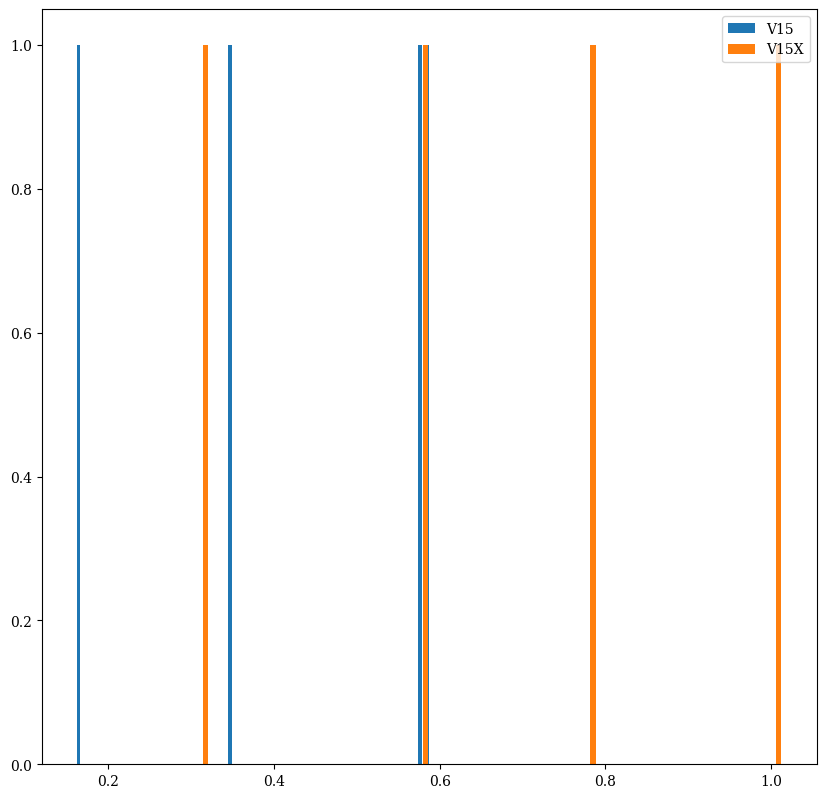

In [43]:
caspian_edge



display(caspian_edge[surface_cols])



histograms_and_deltas(caspian_edge.query("label == 'V20'"),caspian_edge.query("label == 'V15'"),label="V20")
print('------------------------------')
histograms_and_deltas(caspian_edge.query("label == 'V20X'"),caspian_edge.query("label == 'V15'"),label="V20X")
print('-------------------------------')
histograms_and_deltas(caspian_edge.query("label == 'V15X'"),caspian_edge.query("label == 'V15'"),label="V15X")







### Bering glacier

In [44]:
display(bering_glacier[surface_cols])
print("delta V20= ", bering_glacier.query("label == 'V20'")['mean_error'] - bering_glacier.query("label == 'V15'")['mean_error'])
print("delta V20X= ", bering_glacier.query("label == 'V20X'")['mean_error'] - bering_glacier.query("label == 'V15'")['mean_error'])
print("delta V15X= ", bering_glacier.query("label == 'V15X'")['mean_error'] - bering_glacier.query("label == 'V15'")['mean_error'])

,latitude_ERA,longitude_ERA,prediction_error_1,prediction_error_2,prediction_error_3,prediction_error_4,mean_error,variance,label
134395,60.281,-143.466667,0.999268,1.406268,3.630907,3.156039,2.298120,1.290318,V15
134395,60.281,-143.466667,1.589961,2.297741,3.069919,2.336465,2.323521,0.604443,V20
134395,60.281,-143.466667,-1.058485,2.912301,1.157291,-1.206690,0.451104,1.964971,V15X
134395,60.281,-143.466667,1.190805,1.732671,-0.002094,0.626320,0.886926,0.745184,V20X


delta V20=  134395    0.025401
Name: mean_error, dtype: float32
delta V20X=  134395   -1.411195
Name: mean_error, dtype: float32
delta V15X=  134395   -1.847016
Name: mean_error, dtype: float32


### Juncal glacier

In [45]:
display(juncal_glacier[surface_cols])
print("delta V20= ", juncal_glacier.query("label == 'V20'")['mean_error'] - juncal_glacier.query("label == 'V15'")['mean_error'])
print("delta V20X= ", juncal_glacier.query("label == 'V20X'")['mean_error'] - juncal_glacier.query("label == 'V15'")['mean_error'])
print("delta V15X= ", juncal_glacier.query("label == 'V15X'")['mean_error'] - juncal_glacier.query("label == 'V15'")['mean_error'])

,latitude_ERA,longitude_ERA,prediction_error_1,prediction_error_2,prediction_error_3,prediction_error_4,mean_error,variance,label
6228,-33.021066,-70.08,1.223365,1.459444,1.337714,3.010985,1.757877,0.840948,V15
6228,-33.021066,-70.08,6.167937,2.761115,3.667847,5.877738,4.618659,1.667339,V20
6228,-33.021066,-70.08,0.982858,2.754087,1.506604,2.594818,1.959592,0.855169,V15X
6228,-33.021066,-70.08,3.912487,4.008329,4.849799,5.089136,4.464938,0.592012,V20X


delta V20=  6228    2.860782
Name: mean_error, dtype: float32
delta V20X=  6228    2.70706
Name: mean_error, dtype: float32
delta V15X=  6228    0.201714
Name: mean_error, dtype: float32


## Single grid points

In [46]:

singles = [lake_natron, 
           lake_natron_northern_edge, 
           lake_blanche,
           salt_lake_city, 
           farah_province, 
           gujarat_province, 
           toshka_lakes, 
           bering_glacier, 
           juncal_glacier,
          ]

names = ['Lake Natron centre', 
           'Lake Natrom, north', 
           'Lake Blanche',
           'Great Salt Lake Desert', 
           'Farah Province', 
           'Gujarat Province', 
           'Toshka Lakes', 
           'Bering Glacier', 
           'Juncal Glacier',
          ]







0 Lake Natron centre
1 Lake Natrom, north
2 Lake Blanche
3 Great Salt Lake Desert
4 Farah Province
5 Gujarat Province
6 Toshka Lakes
7 Bering Glacier
8 Juncal Glacier


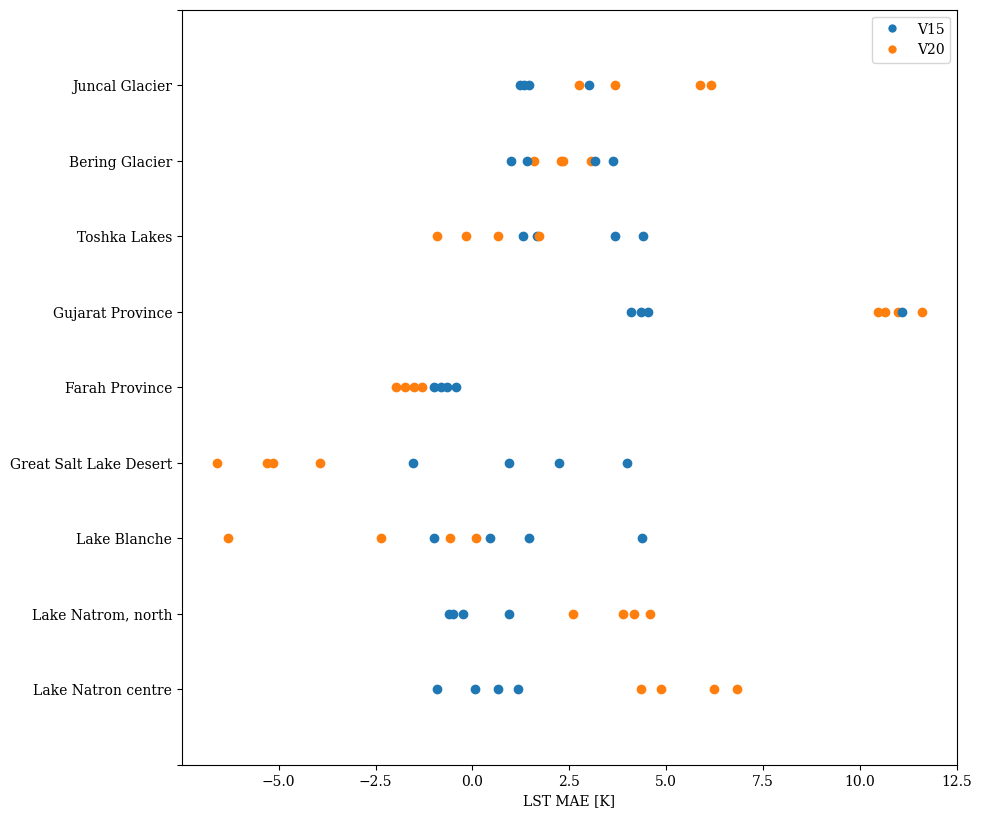

In [47]:
import sys
import numpy as np 
from matplotlib.lines import Line2D


plt.rcParams["font.family"] = "serif"

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)


x = np.arange(len(names))



for i in range(len(names)):
    print(i,names[i])
    df = singles[i]
    xi=x[i]
    
    
    y = df[['prediction_error_1','prediction_error_2','prediction_error_3','prediction_error_4']].to_numpy()
    
    V15  = y[0,:]
    V20  = y[1,:]
    V15X = y[2,:]
    V20X = y[3,:]
    
    
    for j in range(4):
        ax.scatter(V15[j],xi,c="C0",label="V15")
        ax.scatter(V20[j],xi,c="C1",label="V20")
        #ax.scatter(V20X[j],xi,c="C2",label="V20X")


    

# get the xticks, which are the numeric location of the ticks
yticks = ax.get_yticks()

# get the xticks and convert the values in the array to str type
yticklabels = list(map(str, ax.get_yticks()))

# update the string to be changed
for k in range(len(names)):
    
    yticklabels[k+1] = names[k]
    
yticklabels[0] = ''
yticklabels[-1] = ''


# set the xticks and the labels
_ = ax.set_yticks(yticks, yticklabels)
    

    
ax.set_xlabel('LST MAE [K]')
#plt.legend()

colors = ['C0', 'C1']
lines = [Line2D([0], [0], marker='o', color='w',markerfacecolor=c, markersize=7) for c in colors]
labels = ['V15','V20']
plt.legend(lines, labels)

plt.savefig(f"images/categories_v15_v20.png", bbox_inches="tight",dpi=300)


0 Lake Natron centre
1 Lake Natrom, north
2 Lake Blanche
3 Great Salt Lake Desert
4 Farah Province
5 Gujarat Province
6 Toshka Lakes
7 Bering Glacier
8 Juncal Glacier


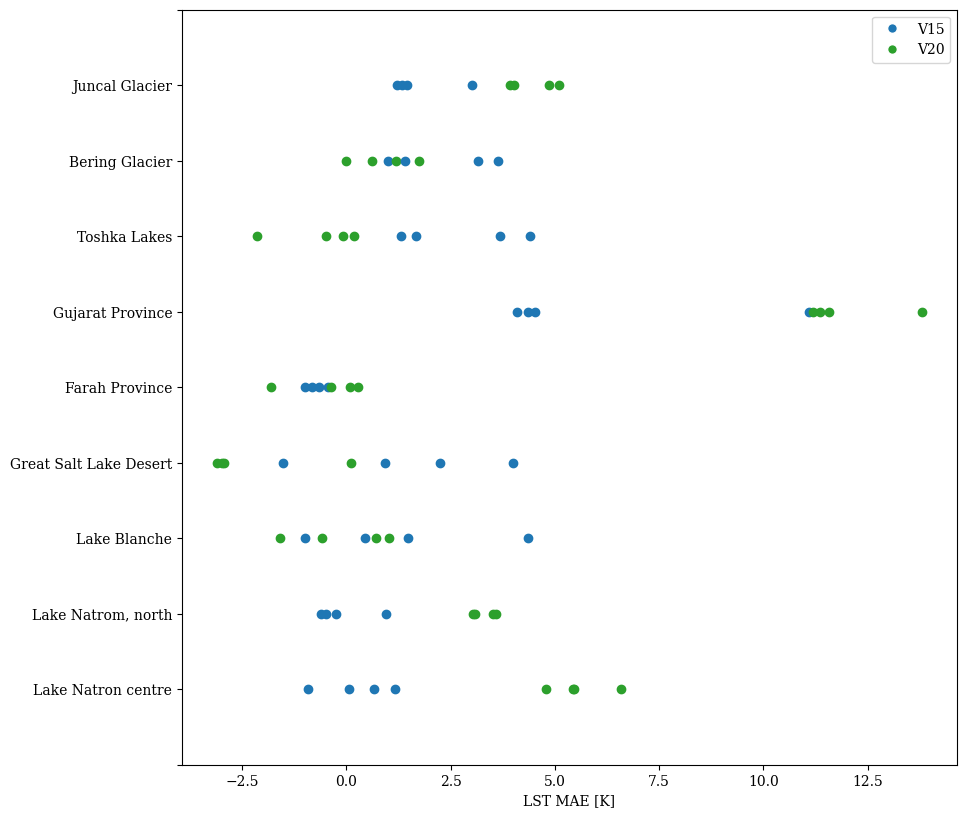

In [48]:
import sys
import numpy as np 
from matplotlib.lines import Line2D


plt.rcParams["font.family"] = "serif"

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)


x = np.arange(len(names))



for i in range(len(names)):
    print(i,names[i])
    df = singles[i]
    xi=x[i]
    
    
    y = df[['prediction_error_1','prediction_error_2','prediction_error_3','prediction_error_4']].to_numpy()
    
    V15  = y[0,:]
    V20  = y[1,:]
    V15X = y[2,:]
    V20X = y[3,:]
    
    
    for j in range(4):
        ax.scatter(V15[j],xi,c="C0",label="V15")
        #ax.scatter(V20[j],xi,c="C1",label="V20")
        ax.scatter(V20X[j],xi,c="C2",label="V20X")


    

# get the xticks, which are the numeric location of the ticks
yticks = ax.get_yticks()

# get the xticks and convert the values in the array to str type
yticklabels = list(map(str, ax.get_yticks()))

# update the string to be changed
for k in range(len(names)):
    
    yticklabels[k+1] = names[k]
    
yticklabels[0] = ''
yticklabels[-1] = ''


# set the xticks and the labels
_ = ax.set_yticks(yticks, yticklabels)
    

    
ax.set_xlabel('LST MAE [K]')
#plt.legend()

colors = ['C0', 'C2']
lines = [Line2D([0], [0], marker='o', color='w',markerfacecolor=c, markersize=7) for c in colors]
labels = ['V15','V20']
plt.legend(lines, labels)

plt.savefig(f"images/categories_v15_v20X.png", bbox_inches="tight",dpi=300)


In [49]:
toshka_lakes

,latitude_ERA,longitude_ERA,MODIS_LST,prediction_error_1,prediction_1,prediction_error_2,prediction_2,prediction_error_3,prediction_3,prediction_error_4,...,cvlFr_change_is_significant,oceanFr_change_is_significant,si10Fr_change_is_significant,dl_change_is_significant,z_change_is_significant,bitstring,median_error,mean_error,variance,label
70081,23.185004,30.9,318.107666,1.667985,316.439697,3.682419,314.425262,1.315017,316.792664,4.408886,...,False,False,False,True,False,1001000,2.675202,2.768577,1.511055,V15
70081,23.185004,30.9,318.107666,0.662095,317.445587,-0.915258,319.022919,-0.162041,318.269714,1.722857,...,False,False,False,True,False,1001000,0.250027,0.326913,1.131823,V20
70081,23.185004,30.9,318.107666,1.128407,316.979248,2.587530,315.520142,2.403831,315.703857,1.867690,...,False,False,False,True,False,1001000,2.135760,1.996864,0.654577,V15X
70081,23.185004,30.9,318.107666,-2.145674,320.253357,-0.483359,318.591034,-0.078945,318.186615,0.193752,...,False,False,False,True,False,1001000,-0.281152,-0.628556,1.048967,V20X
